<a href="https://colab.research.google.com/github/snwnkang/CS109A_Final/blob/main/Milestone4_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
import time
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from warnings import simplefilter
simplefilter('ignore', category=UserWarning) # ignore 'fit without feature names' warning
simplefilter('ignore', category=FutureWarning) # ignore XGBoost warning about is_categorical_dtype

<h1>Data Importing<h1>
<ul>
<li>full_df contains everything, including the one-hot-encoded/labeled variables and the response all together
<li>pred contains only the predictors
<li>resp contains the response variable Operational Energy
<ul>
<p>The steps below are to roughly prepare the data for usage, getting rid of the index columns and verifying the data is correct<p>

In [2]:
full_df = pd.read_csv("https://raw.githubusercontent.com/snwnkang/CS109A_Final/main/data/Milestone4_data/Full_data.csv")
pred = pd.read_csv("https://raw.githubusercontent.com/snwnkang/CS109A_Final/main/data/Milestone4_data/Predictors_data.csv")
resp = pd.read_csv("https://raw.githubusercontent.com/snwnkang/CS109A_Final/main/data/Milestone4_data/Response_data.csv")

In [3]:
#Dropping index columns
full_df = full_df.drop('Unnamed: 0', axis=1)
pred = pred.drop('Unnamed: 0', axis=1)
resp = resp.drop('Unnamed: 0', axis=1)

In [4]:
full_df.head(5)

,Orientation,nonMassWallR [m^2-K/W],MassWallR [m^2-K/W],RoofR [m^2-K/W],ExteriorFloorR [m^2-K/W],WWRnorth,WWRwest,WWRsouth,WWReast,SHGC,...,Midrise Apartment,Retail,Secondary School,Supermarket,Warehouse,Mass,Steel framed,Wood framed,Metal,OE
0,348,2.88,0.00,8.38,5.38,0.23,0.11,0.58,0.15,0.36,...,0,1,0,0,0,0,0,0,1,141.615293
1,96,3.58,0.00,10.49,6.61,0.32,0.24,0.28,0.48,0.40,...,0,1,0,0,0,0,0,0,1,127.674846
2,182,2.21,0.00,5.52,3.43,0.38,0.37,0.56,0.13,0.38,...,0,0,0,0,0,1,0,0,0,255.768779
3,359,0.00,2.03,5.52,3.08,0.42,0.38,0.37,0.49,0.38,...,1,0,0,0,0,1,0,0,0,126.355396
4,317,2.02,0.00,4.40,4.68,0.90,0.90,0.90,0.90,0.25,...,0,0,0,0,0,0,1,0,0,124.733609


In [5]:
pred.head(5)

,Orientation,nonMassWallR [m^2-K/W],MassWallR [m^2-K/W],RoofR [m^2-K/W],ExteriorFloorR [m^2-K/W],WWRnorth,WWRwest,WWRsouth,WWReast,SHGC,...,Medium Office,Midrise Apartment,Retail,Secondary School,Supermarket,Warehouse,Mass,Steel framed,Wood framed,Metal
0,348,2.88,0.00,8.38,5.38,0.23,0.11,0.58,0.15,0.36,...,0,0,1,0,0,0,0,0,0,1
1,96,3.58,0.00,10.49,6.61,0.32,0.24,0.28,0.48,0.40,...,0,0,1,0,0,0,0,0,0,1
2,182,2.21,0.00,5.52,3.43,0.38,0.37,0.56,0.13,0.38,...,0,0,0,0,0,0,1,0,0,0
3,359,0.00,2.03,5.52,3.08,0.42,0.38,0.37,0.49,0.38,...,0,1,0,0,0,0,1,0,0,0
4,317,2.02,0.00,4.40,4.68,0.90,0.90,0.90,0.90,0.25,...,1,0,0,0,0,0,0,1,0,0


In [6]:
resp.head(5)

,OE
0,141.615293
1,127.674846
2,255.768779
3,126.355396
4,124.733609


<hr>
<hr>
<h1>Polynomial Regression + Lasso Regularization<h1>
<hr>
<hr>

In [7]:
# Separate predictors and response
X, y = pred, resp
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(26000, 34)

In [9]:
X_train.columns

Index(['Orientation', 'nonMassWallR [m^2-K/W]', 'MassWallR [m^2-K/W]',
       'RoofR [m^2-K/W]', 'ExteriorFloorR [m^2-K/W]', 'WWRnorth', 'WWRwest',
       'WWRsouth', 'WWReast', 'SHGC', 'WindowR [m^2-K/W]', 'numFloor',
       'AspectRatio', 'VolumeToFacadeRatio',
       'Packaged Single Zone - gas boiler', 'Packaged Single Zone - heat pump',
       'Variable Air Volume air-cooled chiller - gas boiler',
       'Variable Air Volume air-cooled chiller - heat pump',
       'Variable Air Volume chiller with central - gas boiler',
       'Variable Air Volume chiller with central - heat pump', 'Courthouse',
       'Full Service Restaurant', 'Hospital', 'Large Hotel', 'Medium Office',
       'Midrise Apartment', 'Retail', 'Secondary School', 'Supermarket',
       'Warehouse', 'Mass', 'Steel framed', 'Wood framed', 'Metal'],
      dtype='object')

In [10]:
#dopping one of each categorical predictors
X_train_used = X_train.drop(columns=["Packaged Single Zone - gas boiler" , "Courthouse", "Metal"])

In [11]:
X_test_used = X_test.drop(columns=["Packaged Single Zone - gas boiler" , "Courthouse", "Metal"])

In [12]:
X_train_used.shape, X_test_used.shape

((26000, 31), (6500, 31))

In [13]:
X_train_used.columns

Index(['Orientation', 'nonMassWallR [m^2-K/W]', 'MassWallR [m^2-K/W]',
       'RoofR [m^2-K/W]', 'ExteriorFloorR [m^2-K/W]', 'WWRnorth', 'WWRwest',
       'WWRsouth', 'WWReast', 'SHGC', 'WindowR [m^2-K/W]', 'numFloor',
       'AspectRatio', 'VolumeToFacadeRatio',
       'Packaged Single Zone - heat pump',
       'Variable Air Volume air-cooled chiller - gas boiler',
       'Variable Air Volume air-cooled chiller - heat pump',
       'Variable Air Volume chiller with central - gas boiler',
       'Variable Air Volume chiller with central - heat pump',
       'Full Service Restaurant', 'Hospital', 'Large Hotel', 'Medium Office',
       'Midrise Apartment', 'Retail', 'Secondary School', 'Supermarket',
       'Warehouse', 'Mass', 'Steel framed', 'Wood framed'],
      dtype='object')

In [14]:
X_train_used.head(1)

,Orientation,nonMassWallR [m^2-K/W],MassWallR [m^2-K/W],RoofR [m^2-K/W],ExteriorFloorR [m^2-K/W],WWRnorth,WWRwest,WWRsouth,WWReast,SHGC,...,Large Hotel,Medium Office,Midrise Apartment,Retail,Secondary School,Supermarket,Warehouse,Mass,Steel framed,Wood framed
4825,293,3.6,0.0,5.81,5.56,0.85,0.85,0.85,0.85,0.38,...,0,0,0,1,0,0,0,0,1,0


In [15]:
#extracting quatitative variables
X_train_used_quant = X_train_used.drop(columns=['Packaged Single Zone - heat pump',
       'Variable Air Volume air-cooled chiller - gas boiler',
       'Variable Air Volume air-cooled chiller - heat pump',
       'Variable Air Volume chiller with central - gas boiler',
       'Variable Air Volume chiller with central - heat pump',
       'Full Service Restaurant', 'Hospital', 'Large Hotel', 'Medium Office',
       'Midrise Apartment', 'Retail', 'Secondary School', 'Supermarket',
       'Warehouse', 'Mass', 'Steel framed', 'Wood framed'])
X_test_used_quant = X_test_used.drop(columns=['Packaged Single Zone - heat pump',
       'Variable Air Volume air-cooled chiller - gas boiler',
       'Variable Air Volume air-cooled chiller - heat pump',
       'Variable Air Volume chiller with central - gas boiler',
       'Variable Air Volume chiller with central - heat pump',
       'Full Service Restaurant', 'Hospital', 'Large Hotel', 'Medium Office',
       'Midrise Apartment', 'Retail', 'Secondary School', 'Supermarket',
       'Warehouse', 'Mass', 'Steel framed', 'Wood framed'])

In [16]:
X_train_used_quant.shape , X_test_used_quant.shape

((26000, 14), (6500, 14))

In [17]:
X_train_used_cat = X_train_used.drop(columns=['Orientation', 'nonMassWallR [m^2-K/W]', 'MassWallR [m^2-K/W]',
       'RoofR [m^2-K/W]', 'ExteriorFloorR [m^2-K/W]', 'WWRnorth', 'WWRwest',
       'WWRsouth', 'WWReast', 'SHGC', 'WindowR [m^2-K/W]', 'numFloor',
       'AspectRatio', 'VolumeToFacadeRatio'])
X_test_used_cat = X_test_used.drop(columns=['Orientation', 'nonMassWallR [m^2-K/W]', 'MassWallR [m^2-K/W]',
       'RoofR [m^2-K/W]', 'ExteriorFloorR [m^2-K/W]', 'WWRnorth', 'WWRwest',
       'WWRsouth', 'WWReast', 'SHGC', 'WindowR [m^2-K/W]', 'numFloor',
       'AspectRatio', 'VolumeToFacadeRatio'])

In [18]:
X_train_used_cat.shape , X_test_used_cat.shape

((26000, 17), (6500, 17))

In [19]:
#Scaling quantitative preditcors

In [20]:
scaler = StandardScaler().fit(X_train_used_quant)
X_train_quant_sc = scaler.transform(X_train_used_quant)
X_test_quant_sc = scaler.transform(X_test_used_quant)

In [21]:
X_train_quant_sc.shape , X_test_quant_sc.shape

((26000, 14), (6500, 14))

In [22]:
# Finding the best hyper-parameter alpha

In [23]:
# I will test the alpha values by convention tested in class
alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

In [24]:
# I will test for polynomial to the 30th degree to find the alpha,
# again based on convention of what we did in class
max_degree = 5

In [25]:
# Setting those up, the way we have done in class
include_bias = False
fit_intercept = True
max_iter = 100

In [26]:
poly = PolynomialFeatures(max_degree, include_bias=include_bias).fit(X_train_quant_sc)

In [27]:
X_train_quant_sc_poly = poly.transform(X_train_quant_sc)
X_train_quant_sc_poly.shape

(26000, 11627)

In [28]:
X_test_quant_sc_poly = poly.transform(X_test_quant_sc)
X_test_quant_sc_poly.shape

(6500, 11627)

In [29]:
X_train_used_cat.shape

(26000, 17)

In [30]:
X_train_quant_sc_poly = pd.DataFrame(X_train_quant_sc_poly)
X_train_used_cat = pd.DataFrame(X_train_used_cat, columns = X_test_used_cat.columns)

In [31]:
X_train_used_cat.head()

,Packaged Single Zone - heat pump,Variable Air Volume air-cooled chiller - gas boiler,Variable Air Volume air-cooled chiller - heat pump,Variable Air Volume chiller with central - gas boiler,Variable Air Volume chiller with central - heat pump,Full Service Restaurant,Hospital,Large Hotel,Medium Office,Midrise Apartment,Retail,Secondary School,Supermarket,Warehouse,Mass,Steel framed,Wood framed
4825,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
23440,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
11879,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
11758,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5937,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [32]:
X_train_quant_sc_poly.shape

(26000, 11627)

In [33]:
X_train_quant_sc_poly.columns = X_train_quant_sc_poly.columns.astype(str)

In [34]:
X_train_used_cat.columns = X_train_used_cat.columns.astype(str)

In [35]:
X_train_used_cat.shape

(26000, 17)

In [36]:
X_train_used_cat_reset = X_train_used_cat.reset_index(drop=True)
X_train_quant_sc_poly_reset = X_train_quant_sc_poly.reset_index(drop=True)

In [37]:
X_train_quant_sc_poly_cat = pd.concat([X_train_used_cat_reset, X_train_quant_sc_poly_reset], axis=1)

In [38]:
X_train_quant_sc_poly_cat.shape

(26000, 11644)

In [39]:
max_degree = 2

In [40]:
poly = PolynomialFeatures(max_degree, include_bias=include_bias)

#Fit to the standardized quantitative training data and transform both train and test data
X_train_quant_sc_poly = poly.fit_transform(X_train_quant_sc)
X_test_quant_sc_poly = poly.transform(X_test_quant_sc)

#Convert the transformed training data back to DataFrame and reset index for concatenation
X_train_quant_sc_poly_df = pd.DataFrame(X_train_quant_sc_poly)
X_train_used_cat_reset = X_train_used_cat.reset_index(drop=True)

#Concatenate the categorical and polynomial features DataFrames
X_train_poly_cat = pd.concat([X_train_used_cat_reset, X_train_quant_sc_poly_df], axis=1)

#Get the shapes of the transformed data to confirm the process
X_train_poly_cat_shape = X_train_poly_cat.shape
X_test_quant_sc_poly_shape = X_test_quant_sc_poly.shape

X_train_poly_cat_shape, X_test_quant_sc_poly_shape

((26000, 136), (6500, 119))

In [41]:
fit_intercept = True
max_iter = 100

#Initialize LassoCV with the list of alphas, fit_intercept, and max_iter
#LassoCV will perform cross-validation to find the best alpha value
lasso_cv = LassoCV(alphas=alpha_list, fit_intercept=fit_intercept, max_iter=max_iter, cv=5, random_state=42)

#Fit the LassoCV model to the training data
X_train_poly_cat.columns = X_train_poly_cat.columns.astype(str)

#Now fit the LassoCV model to the training data
lasso_cv.fit(X_train_poly_cat, y_train.values.ravel())

#The best alpha value after cross-validation
best_alpha = lasso_cv.alpha_

#Coefficients of the Lasso model
lasso_coefficients = lasso_cv.coef_

#Performance metrics: mean squared error for each alpha
mse_path = lasso_cv.mse_path_

#Average mean squared error for each alpha
avg_mse = mse_path.mean(axis=1)

#R-squared score on the training data
r_squared_train = lasso_cv.score(X_train_poly_cat, y_train)

best_alpha, avg_mse, r_squared_train

(0.01,
 array([297.76955553, 287.14796908, 287.17201641, 287.18894266,
        287.19263782]),
 0.9939784713678153)

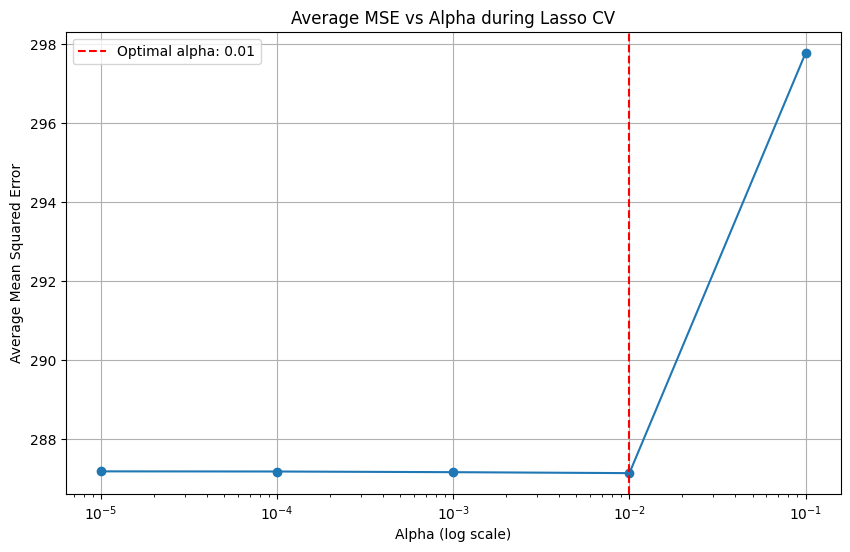

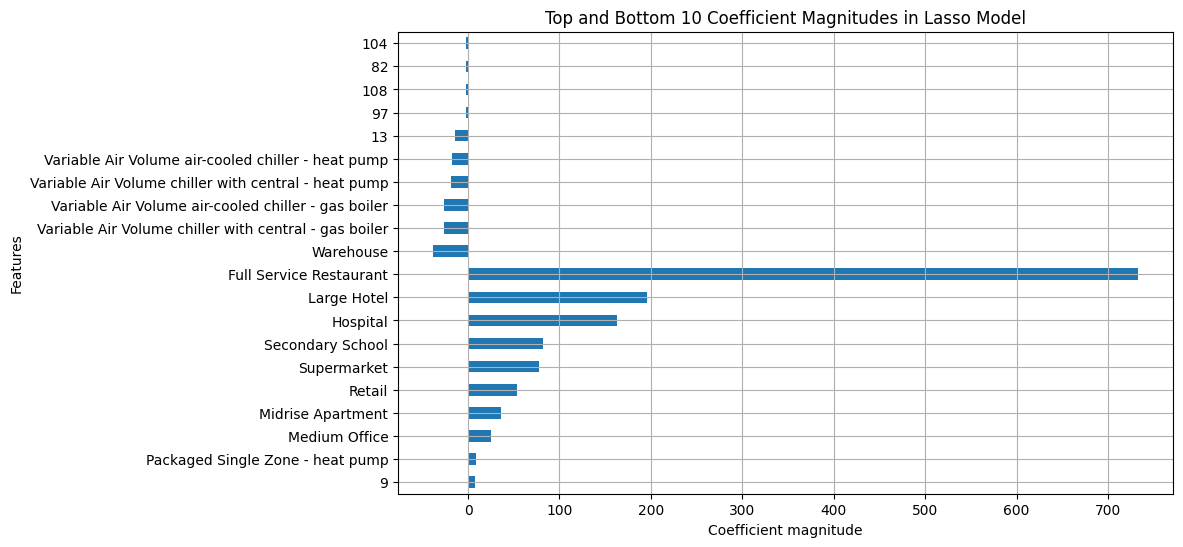

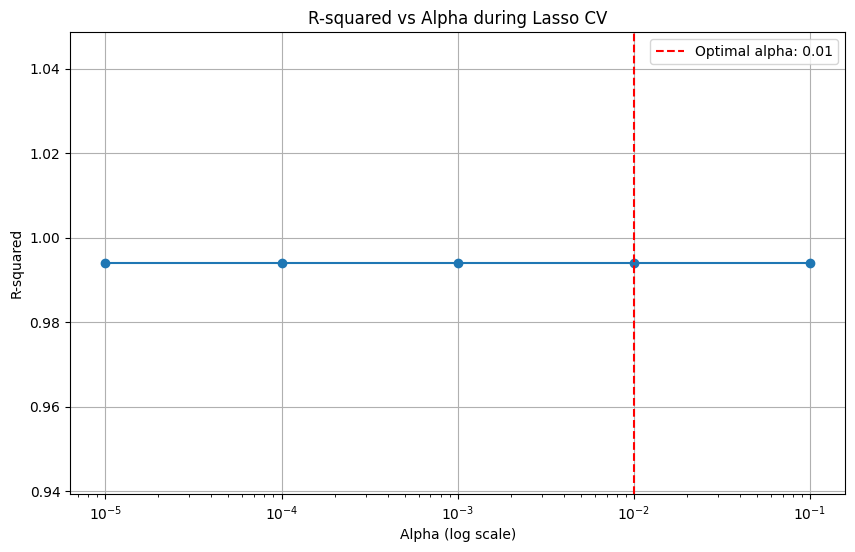

In [42]:
plt.figure(figsize=(10, 6))
plt.semilogx(lasso_cv.alphas_, avg_mse, '-o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Average Mean Squared Error')
plt.title('Average MSE vs Alpha during Lasso CV')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Optimal alpha: {best_alpha}')
plt.legend()
plt.grid(True)
plt.show()

#Plot the coefficient magnitudes
plt.figure(figsize=(10, 6))
coefs = pd.Series(lasso_coefficients, index=X_train_poly_cat.columns)
sorted_coefs = coefs.sort_values()
top_coefs = sorted_coefs[-10:].append(sorted_coefs[:10])  #show top and bottom 10
top_coefs.plot(kind='barh')
plt.title('Top and Bottom 10 Coefficient Magnitudes in Lasso Model')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.grid(True)
plt.show()

#R-squared score on the training data
plt.figure(figsize=(10, 6))
r_squared_values = [lasso_cv.score(X_train_poly_cat, y_train) for alpha in lasso_cv.alphas_]
plt.semilogx(lasso_cv.alphas_, r_squared_values, '-o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('R-squared')
plt.title('R-squared vs Alpha during Lasso CV')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Optimal alpha: {best_alpha}')
plt.legend()
plt.grid(True)
plt.show()

**Average MSE vs Alpha during Lasso CV:**

The first plot shows the relationship between different alpha values and the average Mean Squared Error (MSE) across cross-validation folds.
The red dashed line indicates the optimal alpha value (0.01), which is the regularization strength that resulted in the lowest average MSE.
We see that as alpha increases beyond this optimal value, the average MSE increases sharply, indicating that too much regularization is detrimental to the model's performance.

**Top and Bottom 10 Coefficient Magnitudes in Lasso Model:**

The second plot shows the magnitudes of the top and bottom 10 coefficients in the Lasso model.
The features on the left have negative coefficients, and those on the right have positive coefficients.
Large positive values indicate a strong positive impact on the response variable, while large negative values indicate a strong negative impact.
This visualization helps in understanding which features are most influential in the Lasso model. It's important to note that the sign of the coefficient indicates the direction of the relationship, while the magnitude indicates the strength.

**R-squared vs Alpha during Lasso CV:**

The third plot illustrates how the R-squared value of the model varies with different alpha values.
In this plot, we can see that the R-squared value remains fairly consistent across the range of alphas, suggesting that the model's explanatory power is robust to the regularization strength, up until the optimal alpha is reached.
Beyond the optimal alpha, the model's explanatory power isn't shown, but we could expect it to decrease as the model becomes overly regularized.

In [43]:
X_test_poly = poly.transform(X_test_quant_sc)  #Transform the test set with the same polynomial features
X_test_poly_cat = pd.concat([X_test_used_cat.reset_index(drop=True), pd.DataFrame(X_test_poly)], axis=1)
X_test_poly_cat.columns = X_test_poly_cat.columns.astype(str)  #Ensure column names are strings
y_pred_poly = lasso_cv.predict(X_test_poly_cat)

#Calculate performance metrics on the test set
test_mse = mean_squared_error(y_test, y_pred_poly)
test_r2_poly = r2_score(y_test, y_pred_poly)

#Output the test MSE and R-squared values
print(f"Test MSE: {test_mse}")
print(f"Test R-squared: {test_r2_poly}")

#Coefficient analysis
coefs = pd.Series(lasso_cv.coef_, index=X_train_poly_cat.columns)

mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

Test MSE: 302.5812751236815
Test R-squared: 0.9937545763948497


In [44]:
mse_poly, rmse_poly, test_r2_poly

(302.5812751236815, 17.394863469532652, 0.9937545763948497)

In [45]:
coefs

Packaged Single Zone - heat pump                          9.011407
Variable Air Volume air-cooled chiller - gas boiler     -26.111149
Variable Air Volume air-cooled chiller - heat pump      -18.021311
Variable Air Volume chiller with central - gas boiler   -26.394889
Variable Air Volume chiller with central - heat pump    -18.492417
                                                           ...    
114                                                       0.227077
115                                                       1.448140
116                                                       1.380307
117                                                      -1.497874
118                                                       4.629744
Length: 136, dtype: float64

In [46]:
###make a dataframe to save all significant performance metrics for each model
model_comparison = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])

In [47]:
def add_model_results(model_comparison, model_name, mse, rmse, r2):
    # This function appends the results to the dataframe and returns the updated dataframe
    return model_comparison.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }, ignore_index=True)

In [48]:
model_comparison = add_model_results(model_comparison, 'Polynomial Regression with Lasso', mse_poly, rmse_poly, test_r2_poly)

In [49]:
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755


<hr>
Examing the polynomial features and understand interactions
<hr>

In [50]:
original_feature_names = X_train_used_quant.columns

poly_feature_names = poly.get_feature_names_out(input_features=original_feature_names)

combined_feature_names = list(X_train_used_cat.columns) + list(poly_feature_names)

feature_coefficients = pd.Series(lasso_cv.coef_, index=combined_feature_names)

sorted_features = feature_coefficients.abs().sort_values(ascending=False)

print(sorted_features)

Full Service Restaurant                         732.561492
Large Hotel                                     196.112779
Hospital                                        162.613168
Secondary School                                 82.507570
Supermarket                                      77.660246
                                                   ...    
MassWallR [m^2-K/W] RoofR [m^2-K/W]               0.000000
WWReast WindowR [m^2-K/W]                         0.000000
nonMassWallR [m^2-K/W] SHGC                       0.000000
ExteriorFloorR [m^2-K/W]                          0.000000
ExteriorFloorR [m^2-K/W] VolumeToFacadeRatio      0.000000
Length: 136, dtype: float64


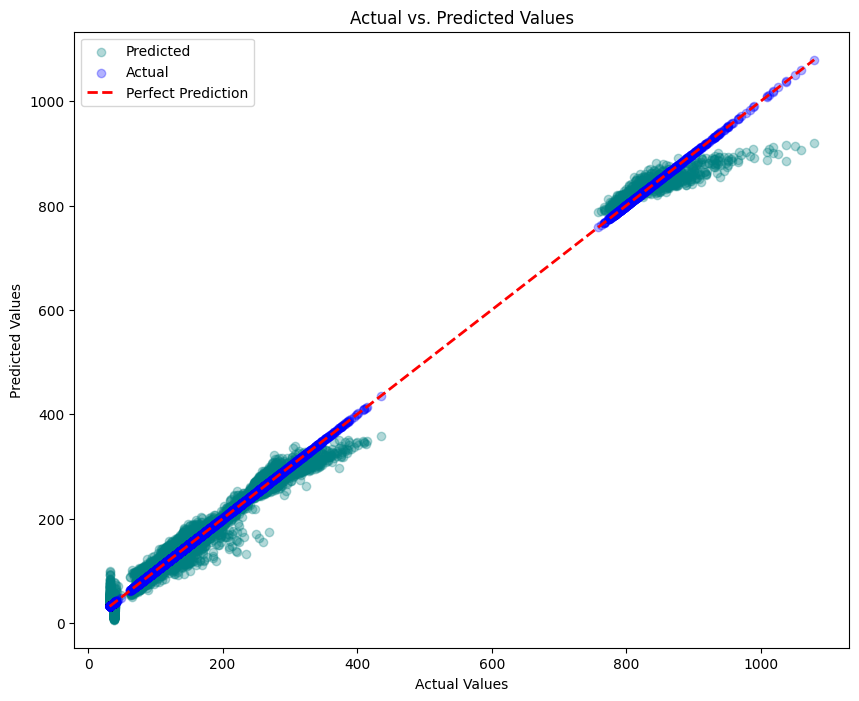

In [51]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_poly, alpha=0.3, c='teal', label='Predicted')
plt.scatter(y_test, y_test, alpha=0.3, c='blue', label='Actual')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

<hr>
<hr>
<h1>Decision Tree<h1>
<hr>
<hr>

In [52]:
lin_model = LinearRegression()

# Train the model
lin_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lin = lin_model.predict(X_test)
mse_lin=mean_squared_error(y_test, y_pred_lin)
rmse_lin=mean_squared_error(y_test, y_pred_lin, squared=False)
r2_lin=r2_score(y_test, y_pred_lin)
print("RMSE:", mean_squared_error(y_test, y_pred_lin, squared=False))
print("R^2:", r2_score(y_test, y_pred_lin))

RMSE: 19.51634662975555
R^2: 0.9921382922085765


In [53]:
model_comparison = add_model_results(model_comparison, 'Linear Regression', mse_lin, rmse_lin, r2_lin)
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138


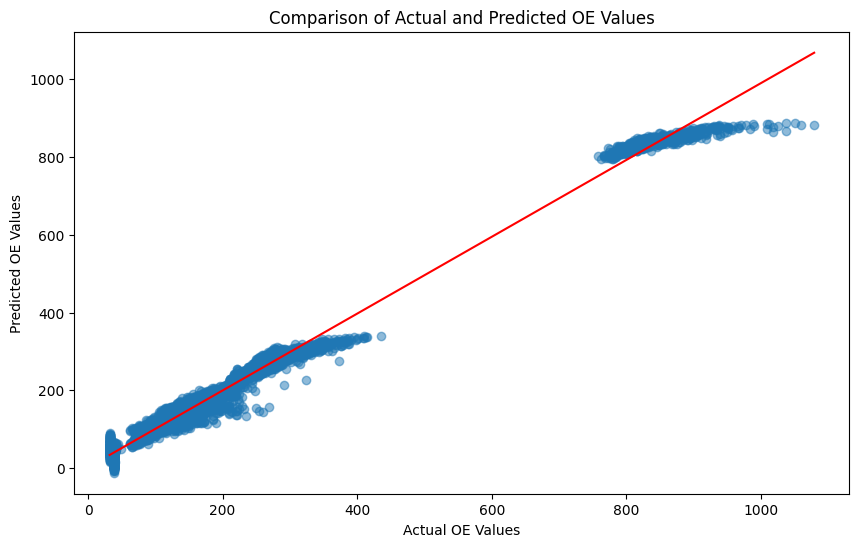

In [54]:
y_test_1d = y_test.values.ravel() if hasattr(y_test, 'values') else np.array(y_test).flatten()
y_pred_lin_1d = y_pred_lin.flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test_1d, y_pred_lin_1d, alpha=0.5)
plt.xlabel('Actual OE Values')
plt.ylabel('Predicted OE Values')
plt.title('Comparison of Actual and Predicted OE Values')

plt.plot(np.unique(y_test_1d), np.poly1d(np.polyfit(y_test_1d, y_pred_lin_1d, 1))(np.unique(y_test_1d)), color='red')

plt.show()

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical and categorical data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Creating a pipeline
lin_model2 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

# Train the model
lin_model2.fit(X_train, y_train)

# Predict and evaluate
y_pred_lin2 = lin_model2.predict(X_test)
mse_lin2 = mean_squared_error(y_test, y_pred_lin2)
rmse_lin2 = mean_squared_error(y_test, y_pred_lin2, squared=False)
r2_lin2 = r2_score(y_test, y_pred_lin2)

print("RMSE with preprocessing:", rmse_lin2)
print("R^2 with preprocessing:", r2_lin2)

RMSE with preprocessing: 19.516233835334702
R^2 with preprocessing: 0.9921383830815489


In [56]:
model_comparison = add_model_results(model_comparison, 'Linear Regression with Preprocessing', mse_lin2, rmse_lin2, r2_lin2)

In [57]:
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138
2,Linear Regression with Preprocessing,380.883383,19.516234,0.992138


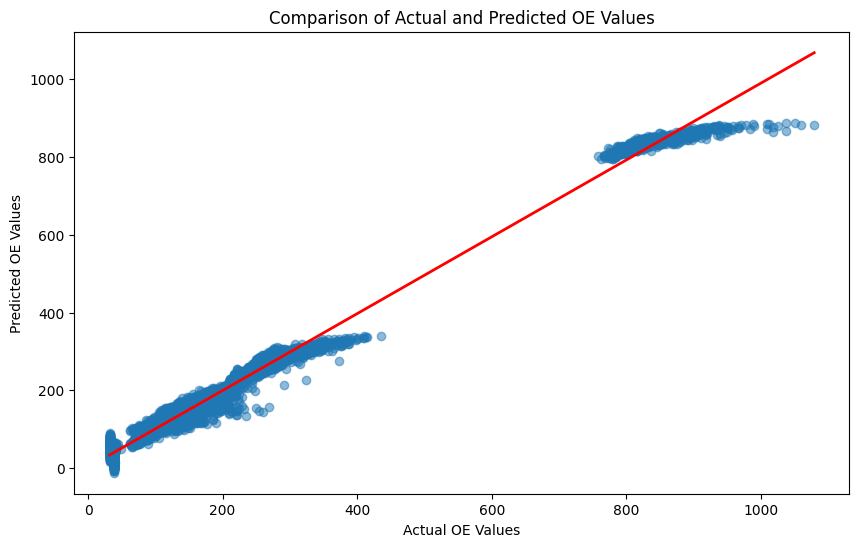

In [58]:
y_test_1d = y_test.values.ravel() if hasattr(y_test, 'values') else np.array(y_test).flatten()
y_pred_lin2_1d = y_pred_lin2.flatten() if y_pred_lin2.ndim > 1 else y_pred_lin2

plt.figure(figsize=(10,6))
plt.scatter(y_test_1d, y_pred_lin2_1d, alpha=0.5)
plt.xlabel('Actual OE Values')
plt.ylabel('Predicted OE Values')
plt.title('Comparison of Actual and Predicted OE Values')

coefficients = np.polyfit(y_test_1d, y_pred_lin2_1d, 1)
polynomial = np.poly1d(coefficients)
xs = np.linspace(y_test_1d.min(), y_test_1d.max())
plt.plot(xs, polynomial(xs), color='red', linewidth=2)

plt.show()

Polynomial Regression with Lasso: This model has the lowest MSE and RMSE, and the highest R-squared value. This indicates that among the models you've run so far, it performs the best in terms of both the closeness of prediction (as indicated by the low MSE and RMSE) and the proportion of variance explained (as indicated by the high R-squared).

Linear Regression and Linear Regression with Preprocessing: These two models have very similar performance metrics to each other. Their MSE and RMSE are higher than those of the Polynomial Regression with Lasso, and their R-squared values are slightly lower. This suggests that the linear model, whether with preprocessing or without, does not predict as closely as the polynomial regression with Lasso and explains slightly less of the variance in the response variable.

The Polynomial Regression with Lasso is currently the best-performing model according to these metrics. It suggests that the relationship between the predictors and response variable may not be strictly linear, and that the Lasso regularization helps in improving the model performance by possibly addressing overfitting and selecting more relevant features.

<hr>
<hr>
<h1>Principal Component Analysis<h1>
<hr>
<hr>

In [59]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_train_std =pd.DataFrame(X_train_std, columns=X_train.columns, index=X_train.index)

X_test_std = scaler.transform(X_test)

In [60]:
X_train_std.describe()

,Orientation,nonMassWallR [m^2-K/W],MassWallR [m^2-K/W],RoofR [m^2-K/W],ExteriorFloorR [m^2-K/W],WWRnorth,WWRwest,WWRsouth,WWReast,SHGC,...,Medium Office,Midrise Apartment,Retail,Secondary School,Supermarket,Warehouse,Mass,Steel framed,Wood framed,Metal
count,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,...,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04
mean,5.288078e-17,1.683440e-16,-6.968785e-18,1.097242e-16,-2.468453e-16,7.365049e-17,-2.193801e-16,1.658161e-16,5.875642e-17,-6.998846e-16,...,2.186285e-17,-7.651999e-18,-3.785006e-17,4.153942e-17,-4.358906e-17,-1.093143e-17,8.608499e-17,4.509214e-18,8.307884e-17,8.143913e-17
std,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,...,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00
min,-1.718003e+00,-1.622739e+00,-3.923043e-01,-1.342811e+00,-1.984770e+00,-1.569685e+00,-1.571429e+00,-1.573391e+00,-1.573567e+00,-1.459689e+00,...,-3.325493e-01,-3.397778e-01,-3.358207e-01,-3.356079e-01,-3.230514e-01,-3.286123e-01,-7.076168e-01,-5.337625e-01,-5.301326e-01,-5.391724e-01
25%,-8.558489e-01,-6.025726e-01,-3.923043e-01,-8.005660e-01,-5.942496e-01,-8.528312e-01,-8.540710e-01,-8.557196e-01,-8.561347e-01,-1.171387e+00,...,-3.325493e-01,-3.397778e-01,-3.358207e-01,-3.356079e-01,-3.230514e-01,-3.286123e-01,-7.076168e-01,-5.337625e-01,-5.301326e-01,-5.391724e-01
50%,-3.274710e-03,-1.196938e-01,-3.923043e-01,-2.583213e-01,3.064921e-01,-1.359773e-01,-1.367133e-01,-1.380485e-01,-1.387026e-01,7.025751e-01,...,-3.325493e-01,-3.397778e-01,-3.358207e-01,-3.356079e-01,-3.230514e-01,-3.286123e-01,-7.076168e-01,-5.337625e-01,-5.301326e-01,-5.391724e-01
75%,8.684585e-01,8.120584e-01,-3.923043e-01,4.194846e-01,7.005666e-01,1.146814e+00,1.146980e+00,1.146205e+00,1.145123e+00,7.025751e-01,...,-3.325493e-01,-3.397778e-01,-3.358207e-01,-3.356079e-01,-3.230514e-01,-3.286123e-01,1.413194e+00,-5.337625e-01,-5.301326e-01,-5.391724e-01
max,1.730612e+00,2.131474e+00,4.256687e+00,2.804129e+00,1.393012e+00,1.448647e+00,1.449025e+00,1.448382e+00,1.447200e+00,9.908770e-01,...,3.007073e+00,2.943100e+00,2.977780e+00,2.979668e+00,3.095482e+00,3.043100e+00,1.413194e+00,1.873492e+00,1.886320e+00,1.854694e+00


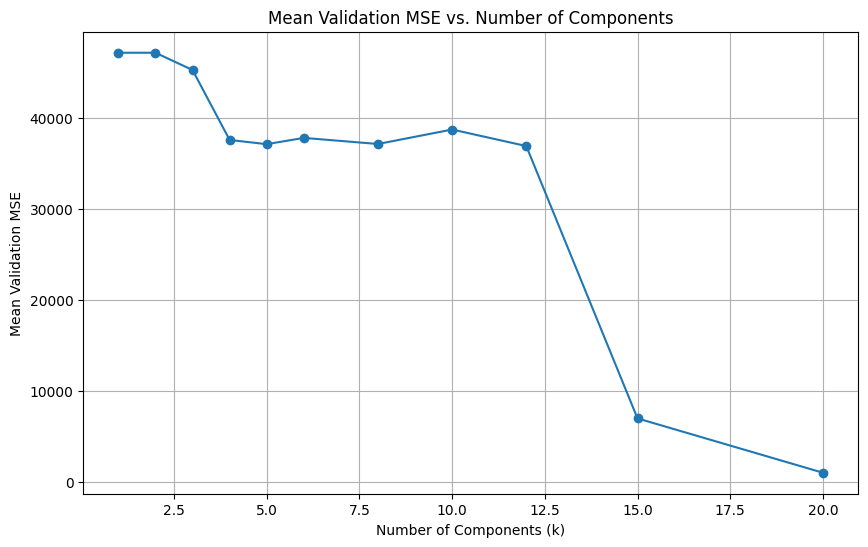

The best k is 20.


In [61]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer, mean_squared_error

# Define the set of k values
k_values = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]
mean_mse_values = []

# For each k, fit PCA and perform 10-fold cross validation for a linear regression model
for k in k_values:
    # Fit and transform using PCA
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_std)

    # Perform 10-fold cross validation
    scores = cross_validate(LinearRegression(), X_train_pca, y_train, cv=10,
                            scoring=make_scorer(mean_squared_error, greater_is_better=False))

    mean_mse_values.append(-scores['test_score'].mean())

# Plot the mean validation MSE for each k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_mse_values, marker='o', linestyle='-')
plt.xlabel('Number of Components (k)')
plt.ylabel('Mean Validation MSE')
plt.title('Mean Validation MSE vs. Number of Components')
plt.grid(True)
plt.show()

best_k = k_values[np.argmin(mean_mse_values)]
print(f"The best k is {best_k}.")

PCR train R^2: 0.9792
PCR test R^2: 0.9792


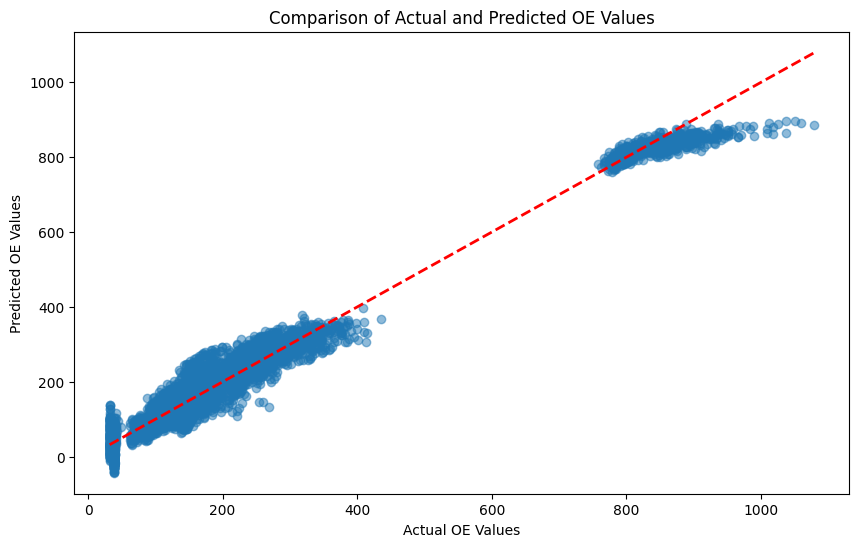

In [62]:
# Fit the PCA transformation on the standardized X_train with n_components equal to the best k
pca_best = PCA(n_components=best_k)
X_train_pca_best = pca_best.fit_transform(X_train_std)
X_test_pca_best = pca_best.transform(X_test_std)

# Fit a linear regression model to the PCA-transformed components
linreg_pcr = LinearRegression()
linreg_pcr.fit(X_train_pca_best, y_train)

# Predict OE values on the PCA-transformed test data
y_pred_pcr = linreg_pcr.predict(X_test_pca_best)

pcr_train_r2 = linreg_pcr.score(X_train_pca_best, y_train)
pcr_test_r2 = linreg_pcr.score(X_test_pca_best, y_test)
print(f"PCR train R^2: {pcr_train_r2:.4f}")
print(f"PCR test R^2: {pcr_test_r2:.4f}")

# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_pcr, alpha=0.5)
plt.xlabel('Actual OE Values')
plt.ylabel('Predicted OE Values')
plt.title('Comparison of Actual and Predicted OE Values')

# Plotting a reference line for perfect predictions (y=x)
plt.plot(np.unique(y_test), np.unique(y_test), color='red', linestyle='--', linewidth=2)

plt.show()

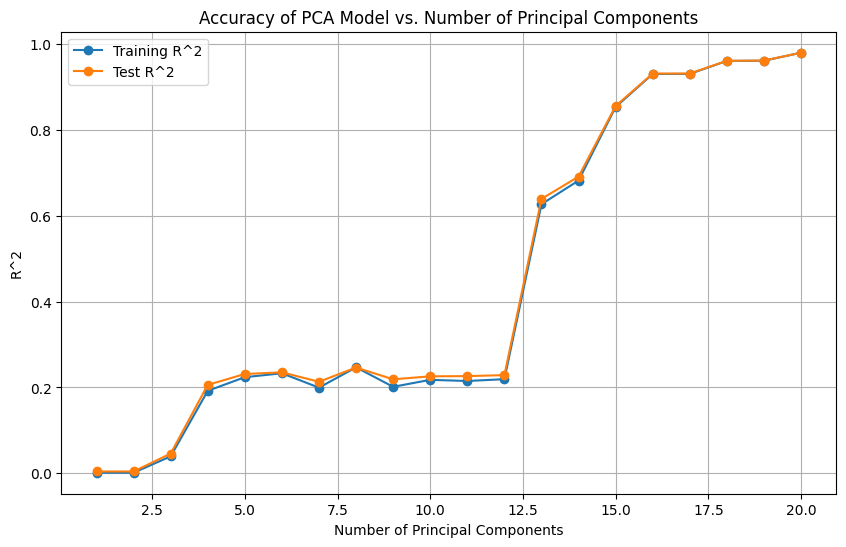

In [63]:

n_components_range = range(1, best_k + 1)
# Initialize lists to store R^2 values
train_r2_values = []
test_r2_values = []

# Loop through different numbers of components and calculate R^2 for each
for n_components in n_components_range:
    # Fit PCA transformation
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)

    # Fit linear regression model to PCA-transformed data
    linreg_pcr = LinearRegression()
    linreg_pcr.fit(X_train_pca, y_train)

    # Calculate R^2 for training set
    train_r2 = linreg_pcr.score(X_train_pca, y_train)

    # Calculate R^2 for test set
    test_r2 = linreg_pcr.score(X_test_pca, y_test)

    # Append R^2 values to the lists
    train_r2_values.append(train_r2)
    test_r2_values.append(test_r2)

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, train_r2_values, marker='o', linestyle='-', label='Training R^2')
plt.plot(n_components_range, test_r2_values, marker='o', linestyle='-', label='Test R^2')
plt.xlabel('Number of Principal Components')
plt.ylabel('R^2')
plt.title('Accuracy of PCA Model vs. Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
mse_pca = mean_squared_error(y_test, y_pred_pcr)
rmse_pca = mean_squared_error(y_test, y_pred_pcr, squared=False)

In [65]:
model_comparison = add_model_results(model_comparison, 'PCA Linear Regression', mse_pca, rmse_pca, pcr_test_r2)
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138
2,Linear Regression with Preprocessing,380.883383,19.516234,0.992138
3,PCA Linear Regression,1009.804470,31.777421,0.979157


In [66]:
# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_train)
# Apply PCA with 2 components
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X_standardized)
X_transformed[:5]

array([[ 2.68465198, -0.99364602],
       [ 3.54961976,  0.1977036 ],
       [-2.92643211,  3.08563856],
       [-4.03741831, -0.03430922],
       [ 0.85045685,  2.02792718]])

In [67]:
# Create a Decision Tree regression model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model's performance (e.g., using Mean Squared Error and R^2)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print(f"Mean Squared Error: {mse_dt:.2f}")
print(f"R^2 Score: {r2_dt:.2f}")

Mean Squared Error: 164.73
R^2 Score: 1.00


In [68]:
model_comparison = add_model_results(model_comparison, 'Decision Tree Regression', mse_dt, rmse_dt, r2_dt)
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138
2,Linear Regression with Preprocessing,380.883383,19.516234,0.992138
3,PCA Linear Regression,1009.804470,31.777421,0.979157
4,Decision Tree Regression,164.727118,12.834606,0.996600


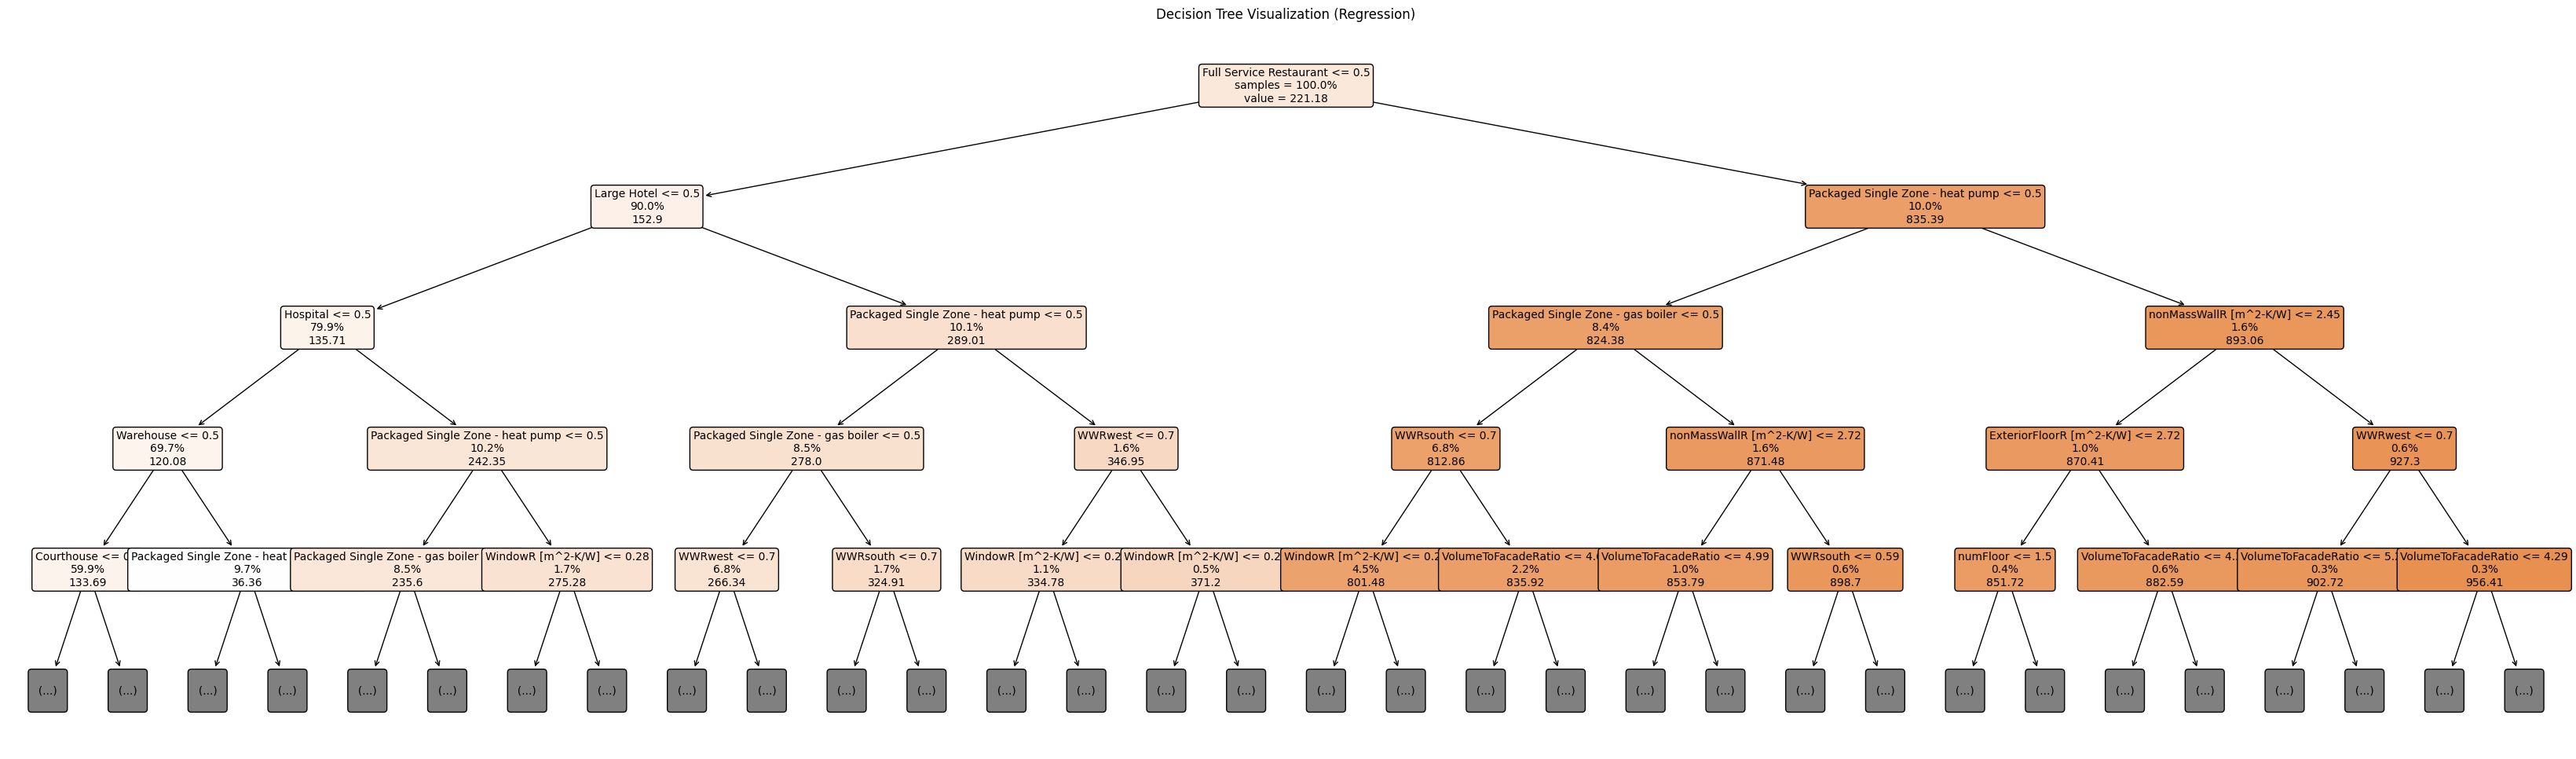

In [69]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Create a Decision Tree regression model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
dt_model.fit(X_train, y_train)

# Convert the index of X to a list of strings for feature_names
feature_names = X.columns.tolist()

# Set parameters for improved readability
plt.figure(figsize=(42, 12))  # Adjust the figure size
plot_tree(
    dt_model,
    filled=True,
    feature_names=feature_names,
    fontsize=10,  # Adjust font size for text
    max_depth=4,  # Limit the tree depth for better visualization
    precision=2,  # Limit decimal precision for values
    label="root",  # Set the label for the root node
    proportion=True,  # Show proportions in leaf nodes
    impurity=False,  # Do not show impurity
    rounded=True,  # Use rounded boxes for nodes
)
plt.title("Decision Tree Visualization (Regression)")
plt.show()

In [70]:
y_pred_poly_flat = y_pred_poly.ravel() if hasattr(y_pred_poly, 'values') else np.array(y_pred_poly).flatten()
y_pred_lin_flat = y_pred_lin.ravel() if hasattr(y_pred_lin, 'values') else np.array(y_pred_lin).flatten()
y_pred_lin2_flat = y_pred_lin2.ravel() if hasattr(y_pred_lin2, 'values') else np.array(y_pred_lin2).flatten()
y_pred_pcr_flat = y_pred_pcr.ravel() if hasattr(y_pred_pcr, 'values') else np.array(y_pred_pcr).flatten()
y_pred_dt_flat = y_pred_dt.ravel() if hasattr(y_pred_dt, 'values') else np.array(y_pred_dt).flatten()
y_test_flat = y_test.values.ravel()

In [71]:
comparison_data = {
    'Actual': y_test_flat,
    'Polynomial Regression with Lasso': y_pred_poly_flat,
    'Linear Regression': y_pred_lin_flat,
    'Linear Regression with Preprocessing': y_pred_lin2_flat,
    'PCA Linear Regression': y_pred_pcr_flat,
    'Decision Tree Regression': y_pred_dt_flat
}

In [72]:
comparison_data

{'Actual': array([881.089132, 147.693614, 295.108297, ..., 208.48666 , 137.805741,
        328.741429]),
 'Polynomial Regression with Lasso': array([879.11021168, 149.0662746 , 277.39578199, ..., 217.29054089,
        141.95854913, 297.30026114]),
 'Linear Regression': array([859.33146813, 148.66217426, 278.21382358, ..., 209.94903733,
        140.65784501, 297.25504378]),
 'Linear Regression with Preprocessing': array([859.33076279, 148.65205185, 278.22334091, ..., 209.95869247,
        140.67695419, 297.2575206 ]),
 'PCA Linear Regression': array([844.53337251, 150.28458067, 244.4075855 , ..., 197.85026326,
        154.75294626, 312.73873807]),
 'Decision Tree Regression': array([854.550388, 140.909934, 303.322666, ..., 209.682368, 136.493421,
        319.419918])}

In [73]:
comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Actual,Polynomial Regression with Lasso,Linear Regression,Linear Regression with Preprocessing,PCA Linear Regression,Decision Tree Regression
0,881.089132,879.110212,859.331468,859.330763,844.533373,854.550388
1,147.693614,149.066275,148.662174,148.652052,150.284581,140.909934
2,295.108297,277.395782,278.213824,278.223341,244.407585,303.322666
3,297.975901,284.199560,285.438306,285.445021,290.587820,299.626000
4,170.019497,167.322717,174.706197,174.701857,151.749508,165.248074
...,...,...,...,...,...,...
6495,326.458920,300.418473,302.560219,302.565138,311.217675,319.266168
6496,858.693898,845.122912,852.525398,852.529005,820.636123,856.541869
6497,208.486660,217.290541,209.949037,209.958692,197.850263,209.682368
6498,137.805741,141.958549,140.657845,140.676954,154.752946,136.493421


Checking model performances so far to compare!

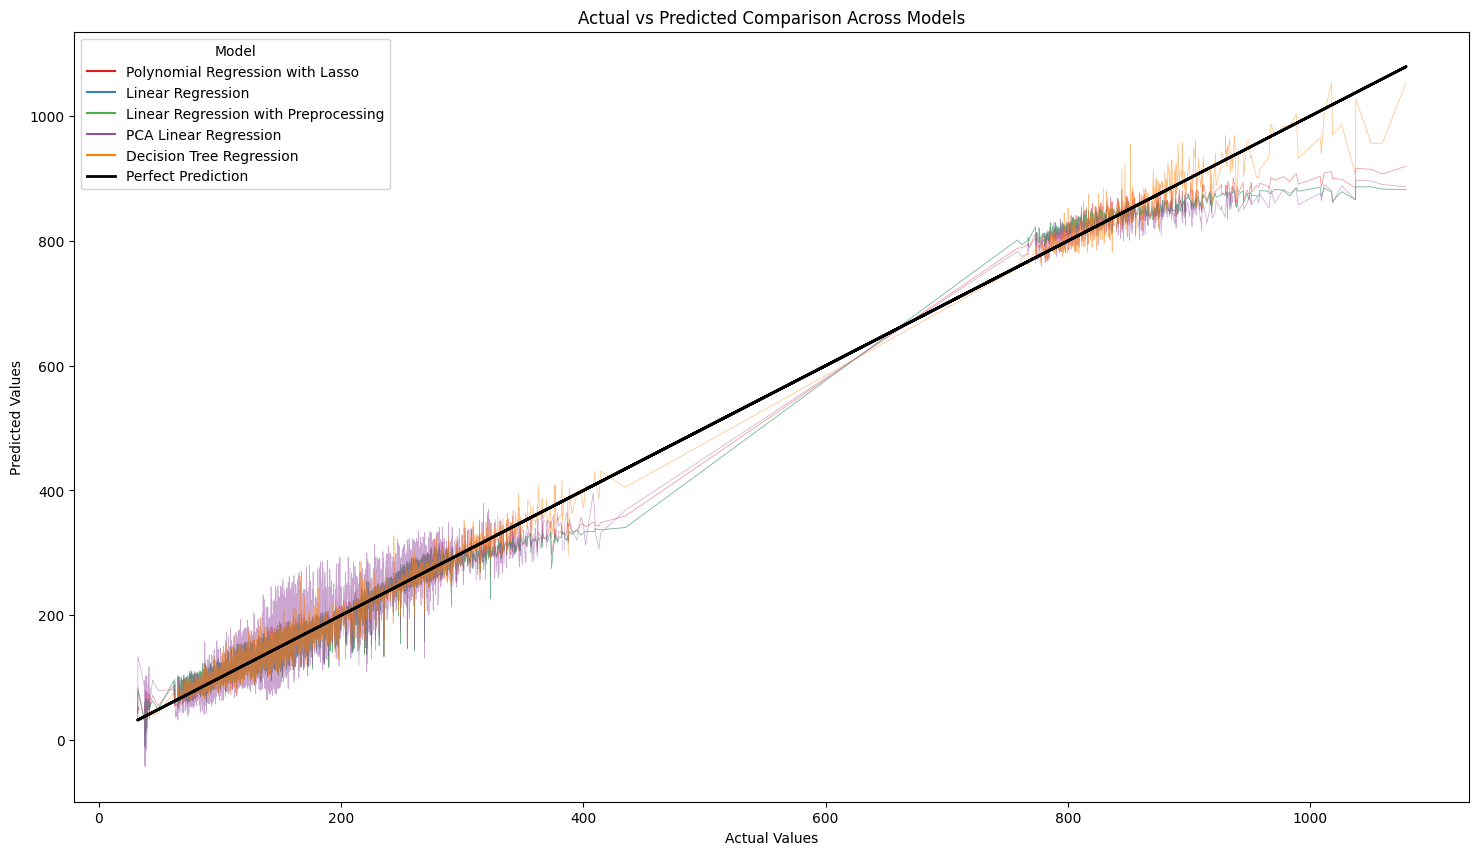

In [74]:
comparison_melted = comparison_df.melt('Actual', var_name='Model', value_name='Predicted')

plt.figure(figsize=(18, 10))
sns.lineplot(x='Actual', y='Predicted', hue='Model', data=comparison_melted, alpha=0.5, palette='Set1', linewidth=0.5)

# Add the actual values line with a darker color and alpha set to 1 for visibility
plt.plot(comparison_df['Actual'], comparison_df['Actual'], label='Perfect Prediction', color='black', lw=2, alpha=1)

plt.title('Actual vs Predicted Comparison Across Models')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(title='Model')
plt.show()

<hr>
<hr>
<h1>Random Forest Regression<h1>
<hr>
<hr>

In [75]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

In [76]:
rf.fit(X_train, y_train.values.ravel())

y_pred_rf = rf.predict(X_test)

In [77]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = rf.score(X_test, y_test)
oob_score = rf.oob_score_

mse_rf, oob_score

(80.28851734132633, 0.9983000796106327)

In [78]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_scaled = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
rf_scaled.fit(X_train_scaled, y_train.values.ravel())

y_pred_rf_scaled = rf_scaled.predict(X_test_scaled)

mse_rf_scaled = mean_squared_error(y_test, y_pred_rf_scaled)

oob_score_scaled = rf_scaled.oob_score_

{
    "MSE": mse_rf,
    "MSE_scaled": mse_rf_scaled,
    "OOB_score": oob_score,
    "OOB_score_scaled": oob_score_scaled
}

{'MSE': 80.28851734132633,
 'MSE_scaled': 80.28423139578837,
 'OOB_score': 0.9983000796106327,
 'OOB_score_scaled': 0.998299588599214}

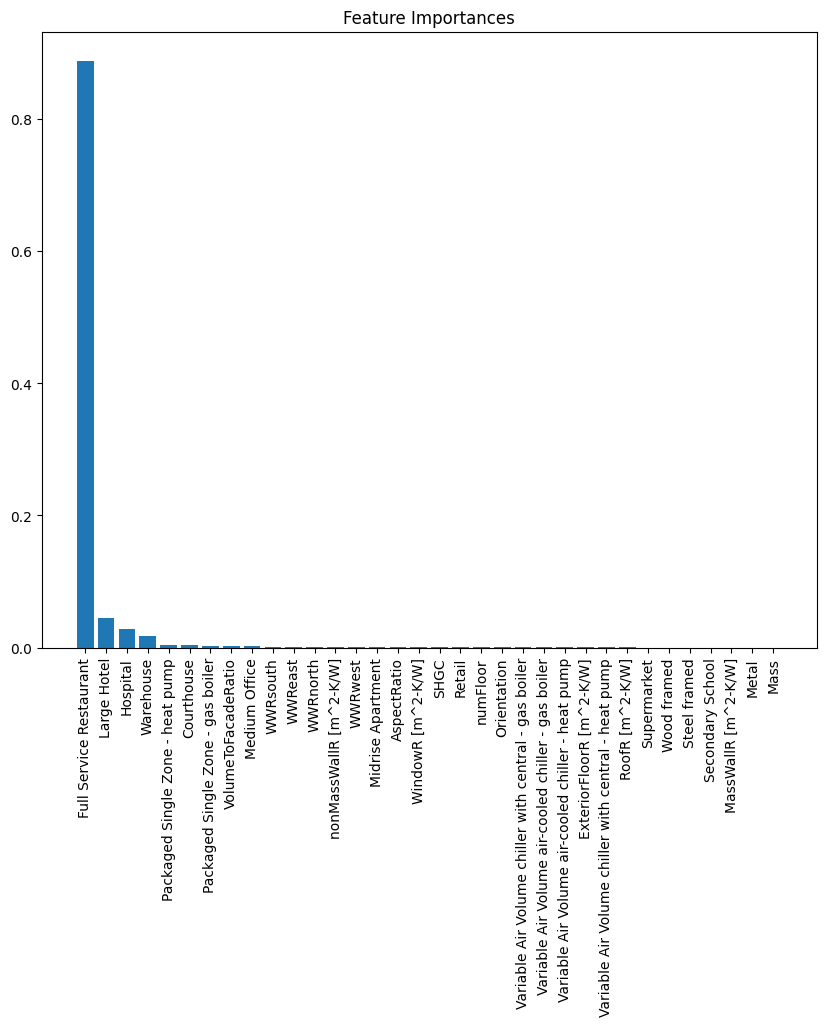

In [79]:
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

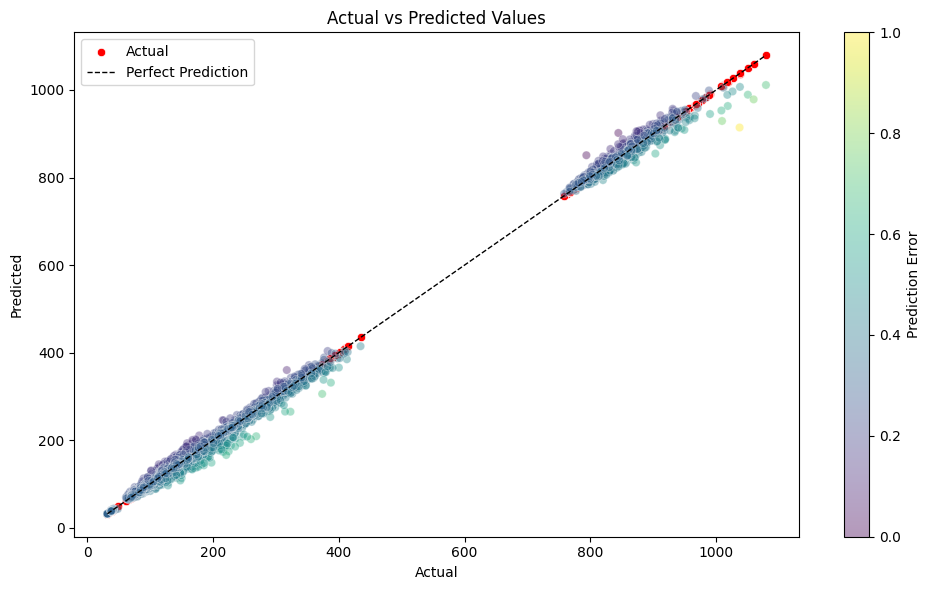

In [80]:
errors = y_test.values.ravel() - y_pred_rf

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x=y_test.values.ravel(), y=y_test.values.ravel(), alpha=1, color='red', label='Actual')
scatter = sns.scatterplot(x=y_test.values.ravel(), y=y_pred_rf, alpha=0.4, hue=errors, palette='viridis', legend=False)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='Perfect Prediction')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.colorbar(scatter.collections[1], label='Prediction Error')
plt.show()

Here is the scatter plot illustrating the relationship between the true values of the response variable and the values predicted by the Random Forest Regressor. Each point represents a different observation from the test set.

The diagonal dashed line represents the line of perfect predictions where the true values are exactly equal to the predicted values. Ideally, all points should fall on or very close to this line, indicating accurate predictions.

The points are very tightly clustered around the line, which visually confirms the high R-squared value we saw earlier. This suggests that the model's predictions are very close to the actual values for most of the test data. However, it's always good to remain cautious of overfitting and validate the model further with cross-validation if needed.

In [81]:
program_columns = [
    "Courthouse",
    "Full Service Restaurant",
    "Hospital",
    "Large Hotel",
    "Medium Office",
    "Midrise Apartment",
    "Retail",
    "Secondary School",
    "Supermarket",
    "Warehouse",
]

wall_columns = [
    "Mass",
    "Steel framed",
    "Wood framed",
    "Metal",
]

equip_columns = [
    "Packaged Single Zone - gas boiler",
    "Packaged Single Zone - heat pump",
    "Variable Air Volume air-cooled chiller - gas boiler",
    "Variable Air Volume air-cooled chiller - heat pump",
    "Variable Air Volume chiller with central - gas boiler",
    "Variable Air Volume chiller with central - heat pump",
]

In [82]:
rf_scaled = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
rf_scaled.fit(X_train_scaled, y_train.values.ravel())

y_pred_rf_scaled = rf_scaled.predict(X_test_scaled)

mse_rf_scaled = mean_squared_error(y_test, y_pred_rf_scaled)

oob_score_scaled = rf_scaled.oob_score_


mse_rf_scaled, oob_score_scaled

(80.28423139578837, 0.998299588599214)

In [83]:
from math import sqrt
rmse_scaled_rf = sqrt(mse_rf_scaled)

param_grid_small = {
    'n_estimators': [10, 50],
    'max_depth': [None, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)

rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_small,
                              cv=2, verbose=2, n_jobs=-1)

rf_grid_search.fit(X_train_scaled, y_train.values.ravel())

best_params_grid = rf_grid_search.best_params_
best_params_grid

Fitting 2 folds for each of 32 candidates, totalling 64 fits


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [84]:
final_rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    oob_score=True,
    random_state=42
)

final_rf.fit(X_train_scaled, y_train.values.ravel())

final_y_pred_rf = final_rf.predict(X_test_scaled)

final_mse_rf = mean_squared_error(y_test, final_y_pred_rf)

final_oob_score_rf = final_rf.oob_score_

final_mse_rf, final_oob_score_rf

(80.5747467750846, 0.9982450345346688)

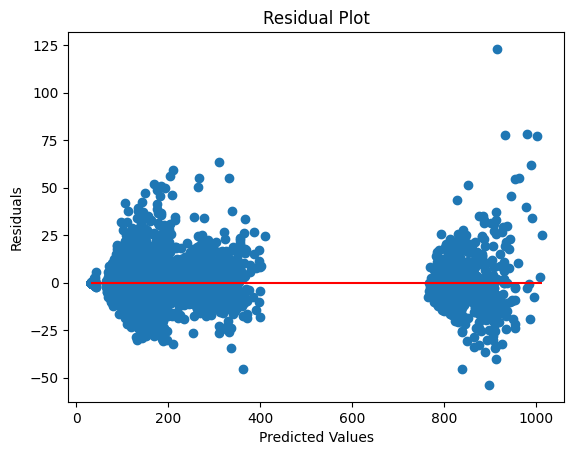

In [85]:
y_test_values = y_test.values.ravel() #to convert to 1-D array

residuals = y_test_values - final_y_pred_rf

plt.scatter(final_y_pred_rf, residuals)
plt.hlines(y=0, xmin=final_y_pred_rf.min(), xmax=final_y_pred_rf.max(), colors='r')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

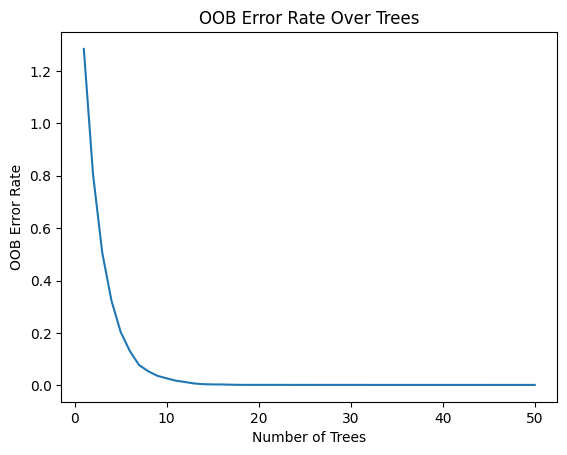

In [86]:
oob_scores = []

rf = RandomForestRegressor(n_estimators=1, warm_start=True, oob_score=True,
                           max_features='auto', random_state=42)

for n_trees in range(1, 51):
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_train_scaled, y_train.values.ravel())

    oob_scores.append(rf.oob_score_)

oob_errors = [1 - oob for oob in oob_scores]

plt.plot(range(1, 51), oob_errors)
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Over Trees')
plt.show()

In [87]:
model_metrics = {
    'Model': [],
    'MSE': [],
    'RMSE': [],
    'OOB Score': [],
}

In [88]:
model_metrics['Model'].append('Random Forest pre_tuning')
model_metrics['MSE'].append(mse_rf_scaled)
model_metrics['RMSE'].append(rmse_scaled_rf)
model_metrics['OOB Score'].append(oob_score_scaled)

In [89]:
final_rmse_scaled_rf = sqrt(final_mse_rf)

model_metrics['Model'].append('Random Forest post-tuning')
model_metrics['MSE'].append(final_mse_rf)
model_metrics['RMSE'].append(final_rmse_scaled_rf)
model_metrics['OOB Score'].append(final_oob_score_rf)

In [90]:
model_metrics

{'Model': ['Random Forest pre_tuning', 'Random Forest post-tuning'],
 'MSE': [80.28423139578837, 80.5747467750846],
 'RMSE': [8.960146840079595, 8.9763437308898],
 'OOB Score': [0.998299588599214, 0.9982450345346688]}

In [91]:
metrics_df = pd.DataFrame(model_metrics)
metrics_df

,Model,MSE,RMSE,OOB Score
0,Random Forest pre_tuning,80.284231,8.960147,0.998300
1,Random Forest post-tuning,80.574747,8.976344,0.998245


In [92]:
final_r2_rf = final_rf.score(X_test_scaled, y_test)
rmse_rf = sqrt(mse_rf)
final_rmse_rf = sqrt(final_mse_rf)

In [93]:
model_comparison = add_model_results(model_comparison, 'Random Forest (Pre-tuning)', mse_rf, rmse_rf, r2_rf)

In [94]:
model_comparison = add_model_results(model_comparison, 'Random Forest (Post-tuning)', final_mse_rf, final_rmse_rf, final_r2_rf)

In [95]:
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138
2,Linear Regression with Preprocessing,380.883383,19.516234,0.992138
3,PCA Linear Regression,1009.804470,31.777421,0.979157
4,Decision Tree Regression,164.727118,12.834606,0.996600
5,Random Forest (Pre-tuning),80.288517,8.960386,0.998343
6,Random Forest (Post-tuning),80.574747,8.976344,0.998337


In [96]:
comparison_df['Random Forest (Pre-tuning)'] = y_pred_rf
comparison_df['Random Forest (Post-tuning)'] = final_y_pred_rf

In [97]:
comparison_melted = comparison_df.melt('Actual', var_name='Model', value_name='Predicted')

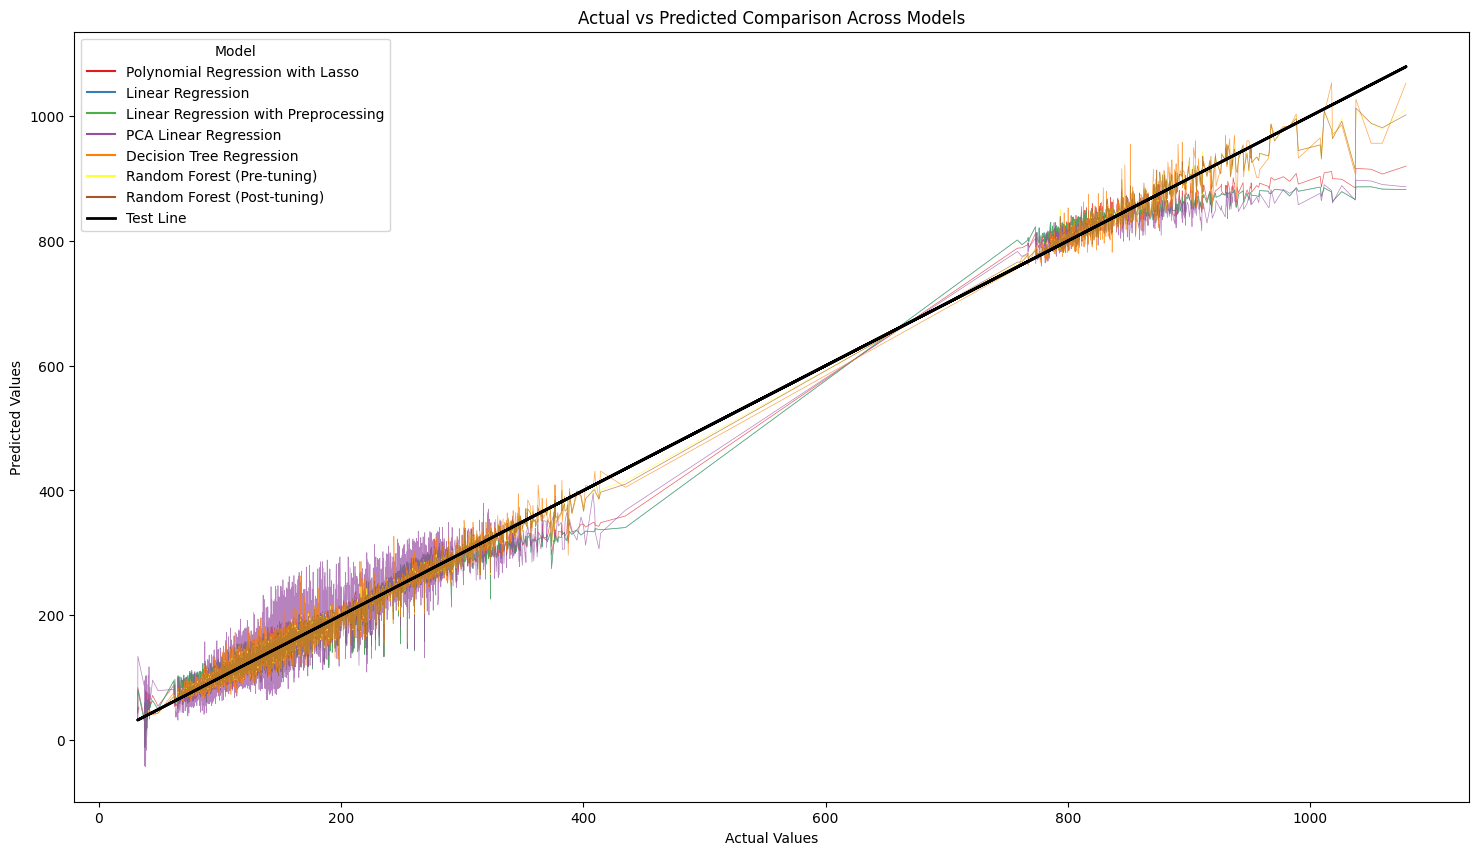

In [98]:
plt.figure(figsize=(18, 10))
sns.lineplot(x='Actual', y='Predicted', hue='Model', data=comparison_melted, alpha=0.7, palette='Set1', linewidth=0.5)
plt.plot(comparison_df['Actual'], comparison_df['Actual'], label='Test Line', color='black', lw=2, alpha=1)
plt.title('Actual vs Predicted Comparison Across Models')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(title='Model')
plt.show()

Interpretations:

The changes in MSE and RMSE are very small, indicating that the hyperparameter tuning did not lead to a significant improvement in the model's ability to minimize the average error in predictions.
The OOB score also shows a very minor decrease, implying that the model's generalization on unseen data is roughly the same before and after tuning.
The lack of significant improvement could be due to several reasons, such as the model already performing near its best with the given data and features, or the hyperparameter space explored during tuning was not extensive enough to find a better set of parameters.
Given that the scores are very close to 1, this could also indicate that the model is already performing very well, and there might be little room for improvement, at least with the hyperparameters that were tuned.

<hr>
<hr>
<h1>Extreme Gradient Boosting<h1>
<hr>
<hr>

In [99]:
continuous_columns = [col for col in pred.columns if col not in (program_columns + wall_columns + equip_columns)]

scaler = StandardScaler()

pred[continuous_columns] = scaler.fit_transform(pred[continuous_columns])

pred.head()

,Orientation,nonMassWallR [m^2-K/W],MassWallR [m^2-K/W],RoofR [m^2-K/W],ExteriorFloorR [m^2-K/W],WWRnorth,WWRwest,WWRsouth,WWReast,SHGC,...,Medium Office,Midrise Apartment,Retail,Secondary School,Supermarket,Warehouse,Mass,Steel framed,Wood framed,Metal
0,1.612736,0.336723,-0.394568,1.517794,0.703114,-1.081111,-1.532441,0.240643,-1.381225,0.414473,...,0,0,1,0,0,0,0,0,0,1
1,-0.804851,0.812136,-0.394568,2.825094,1.397133,-0.741229,-1.041839,-0.891804,-0.136095,0.991374,...,0,0,1,0,0,0,0,0,0,1
2,0.020199,-0.118314,-0.394568,-0.254186,-0.397160,-0.514641,-0.551238,0.165147,-1.456687,0.702923,...,0,0,0,0,0,0,1,0,0,0
3,1.718265,-1.619260,2.098007,-0.254186,-0.594646,-0.363582,-0.513500,-0.552070,-0.098364,0.702923,...,0,1,0,0,0,0,1,0,0,0
4,1.315334,-0.247355,-0.394568,-0.948108,0.308144,1.449123,1.448905,1.448588,1.448616,-1.172006,...,1,0,0,0,0,0,0,1,0,0


In [100]:
#XGBoosting can't have special characters in feature names... remove them
pred.columns = [col.replace('[', '').replace(']', '').replace('<', 'lt').replace('-', '').replace(' ', '_') for col in pred.columns]

pred.columns.tolist()

['Orientation',
 'nonMassWallR_m^2K/W',
 'MassWallR_m^2K/W',
 'RoofR_m^2K/W',
 'ExteriorFloorR_m^2K/W',
 'WWRnorth',
 'WWRwest',
 'WWRsouth',
 'WWReast',
 'SHGC',
 'WindowR_m^2K/W',
 'numFloor',
 'AspectRatio',
 'VolumeToFacadeRatio',
 'Packaged_Single_Zone__gas_boiler',
 'Packaged_Single_Zone__heat_pump',
 'Variable_Air_Volume_aircooled_chiller__gas_boiler',
 'Variable_Air_Volume_aircooled_chiller__heat_pump',
 'Variable_Air_Volume_chiller_with_central__gas_boiler',
 'Variable_Air_Volume_chiller_with_central__heat_pump',
 'Courthouse',
 'Full_Service_Restaurant',
 'Hospital',
 'Large_Hotel',
 'Medium_Office',
 'Midrise_Apartment',
 'Retail',
 'Secondary_School',
 'Supermarket',
 'Warehouse',
 'Mass',
 'Steel_framed',
 'Wood_framed',
 'Metal']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp.values.ravel(), test_size=0.2, random_state=42)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

first_mse_xgb = mean_squared_error(y_test, y_pred_xgb)
first_rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

first_mse_xgb, first_rmse_xgb

(63.26026731316064, 7.953632334547571)

In [102]:
cv_scores = cross_val_score(xgb_model, pred, resp.values.ravel(), scoring='neg_mean_squared_error', cv=5)
cv_rmse_scores = np.sqrt(-cv_scores)

#Calculate the mean and standard deviation of the cross-validated RMSE scores
cv_rmse_mean = cv_rmse_scores.mean()
cv_rmse_std = cv_rmse_scores.std()

cv_rmse_mean, cv_rmse_std

(7.822520234384726, 0.20010231904277284)

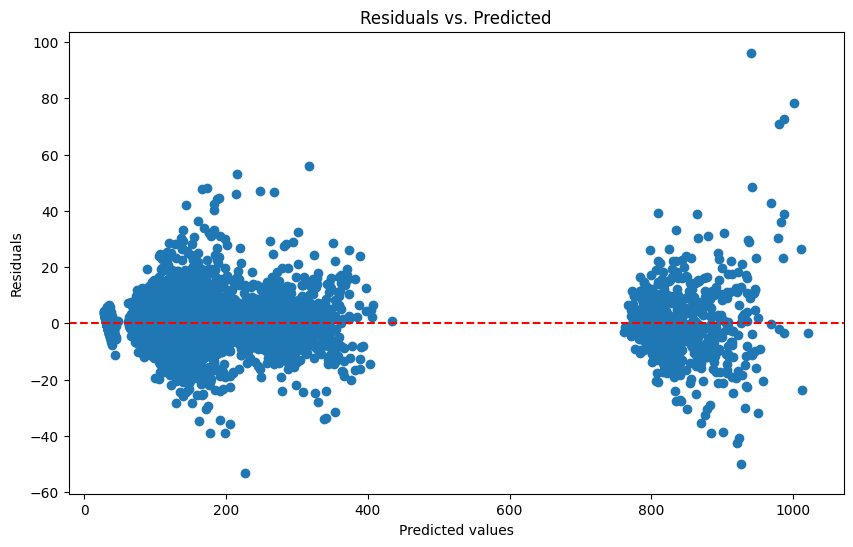

In [103]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb, (y_test - y_pred_xgb))
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

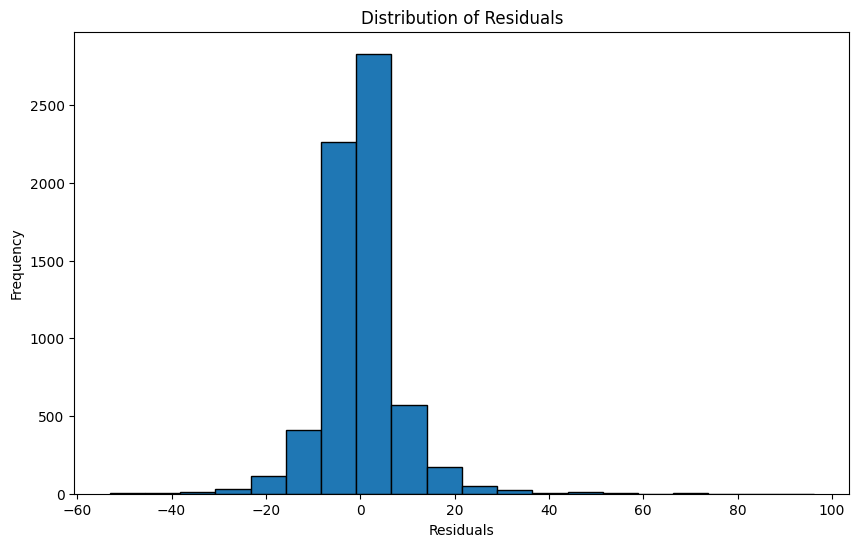

In [104]:
residuals = y_test - y_pred_xgb
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

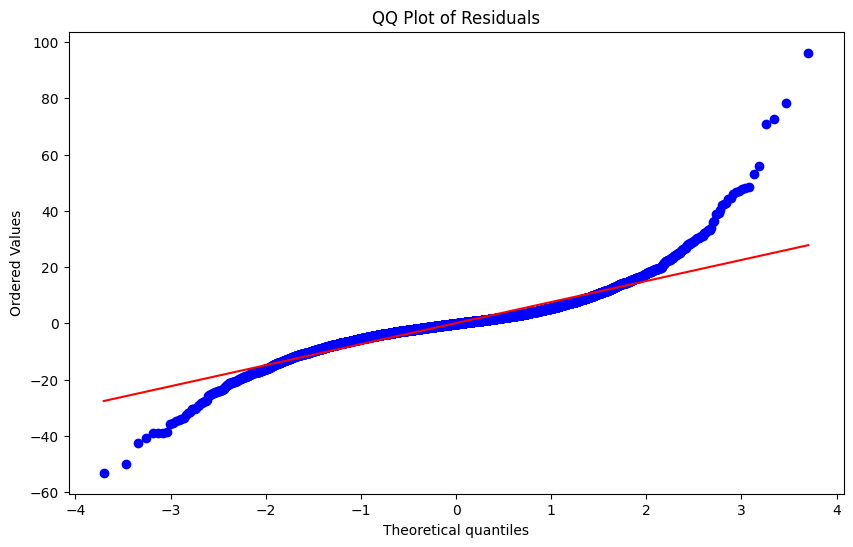

In [105]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

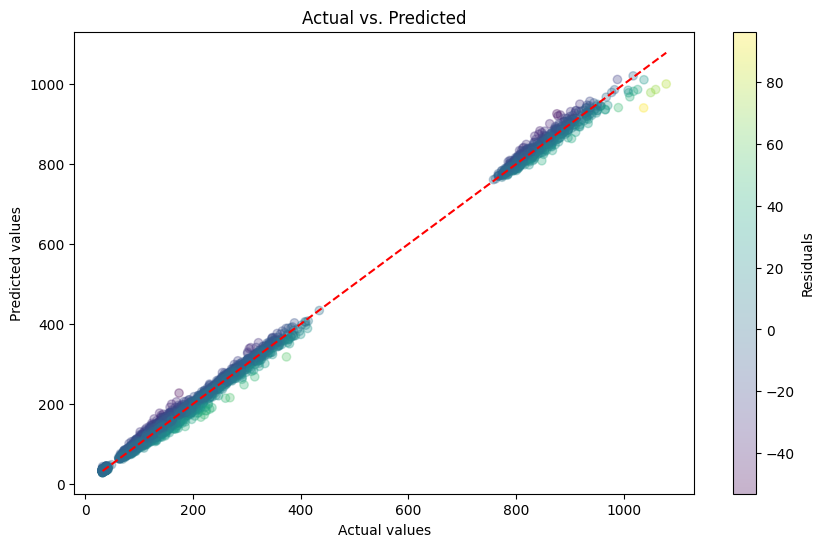

In [106]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(y_test, y_pred_xgb, alpha=0.3, c=residuals, cmap='viridis')

cbar = plt.colorbar(scatter)
cbar.set_label('Residuals')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.title('Actual vs. Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.show()

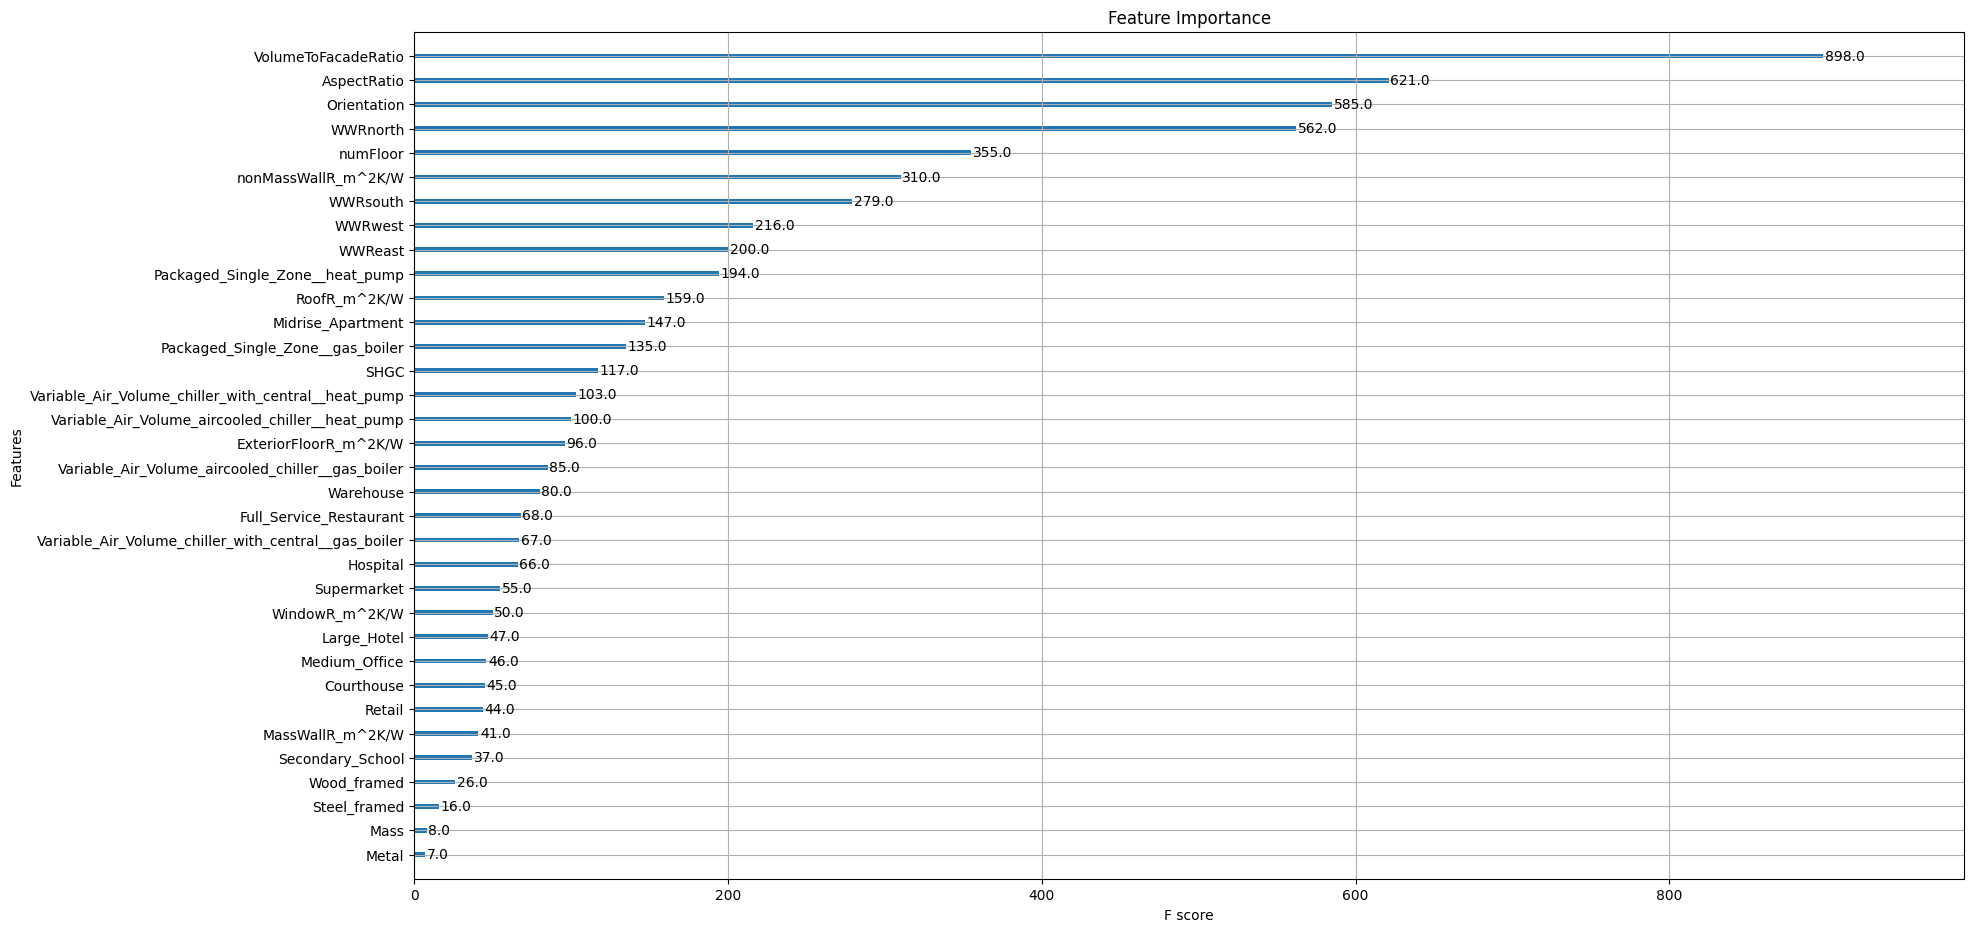

In [107]:
fig, ax = plt.subplots(figsize=(20, 11))

xgb.plot_importance(xgb_model, ax=ax)

plt.title('Feature Importance')
plt.show()

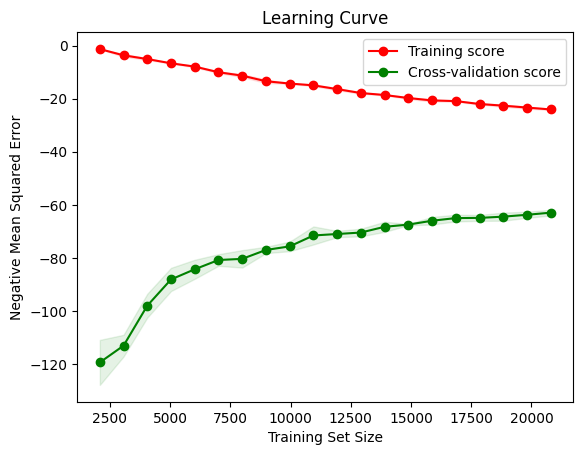

In [108]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 20))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.show()

In [109]:
lc_train_mse = -train_mean[-1]
lc_test_mse = -test_mean[-1]

lc_train_rmse = np.sqrt(lc_train_mse)
lc_test_rmse = np.sqrt(lc_test_mse)

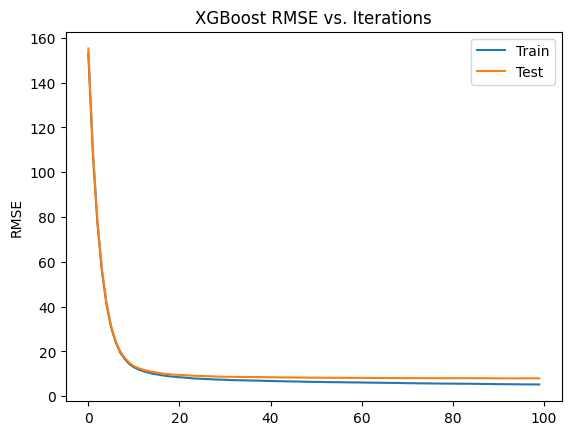

In [110]:
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

results = xgb_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE vs. Iterations')
plt.show()

In [111]:
train_rmse_pre_tuned = results['validation_0']['rmse'][-1]
test_rmse_pre_tuned = results['validation_1']['rmse'][-1]

train_mse_pre_tuned = train_rmse_pre_tuned ** 2
test_mse_pre_tuned = test_rmse_pre_tuned ** 2

In [112]:
model_comparison = add_model_results(
    model_comparison,
    'XGBoost (Pre-tuned)',
    test_mse_pre_tuned,
    test_rmse_pre_tuned,
    xgb_model.score(X_test, y_test)
)

In [113]:
comparison_df['XGBoost (Pre-tuned)'] = y_pred_xgb
comparison_melted = comparison_df.melt('Actual', var_name='Model', value_name='Predicted')

In [114]:
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138
2,Linear Regression with Preprocessing,380.883383,19.516234,0.992138
3,PCA Linear Regression,1009.804470,31.777421,0.979157
4,Decision Tree Regression,164.727118,12.834606,0.996600
5,Random Forest (Pre-tuning),80.288517,8.960386,0.998343
6,Random Forest (Post-tuning),80.574747,8.976344,0.998337
7,XGBoost (Pre-tuned),63.260267,7.953632,0.998694


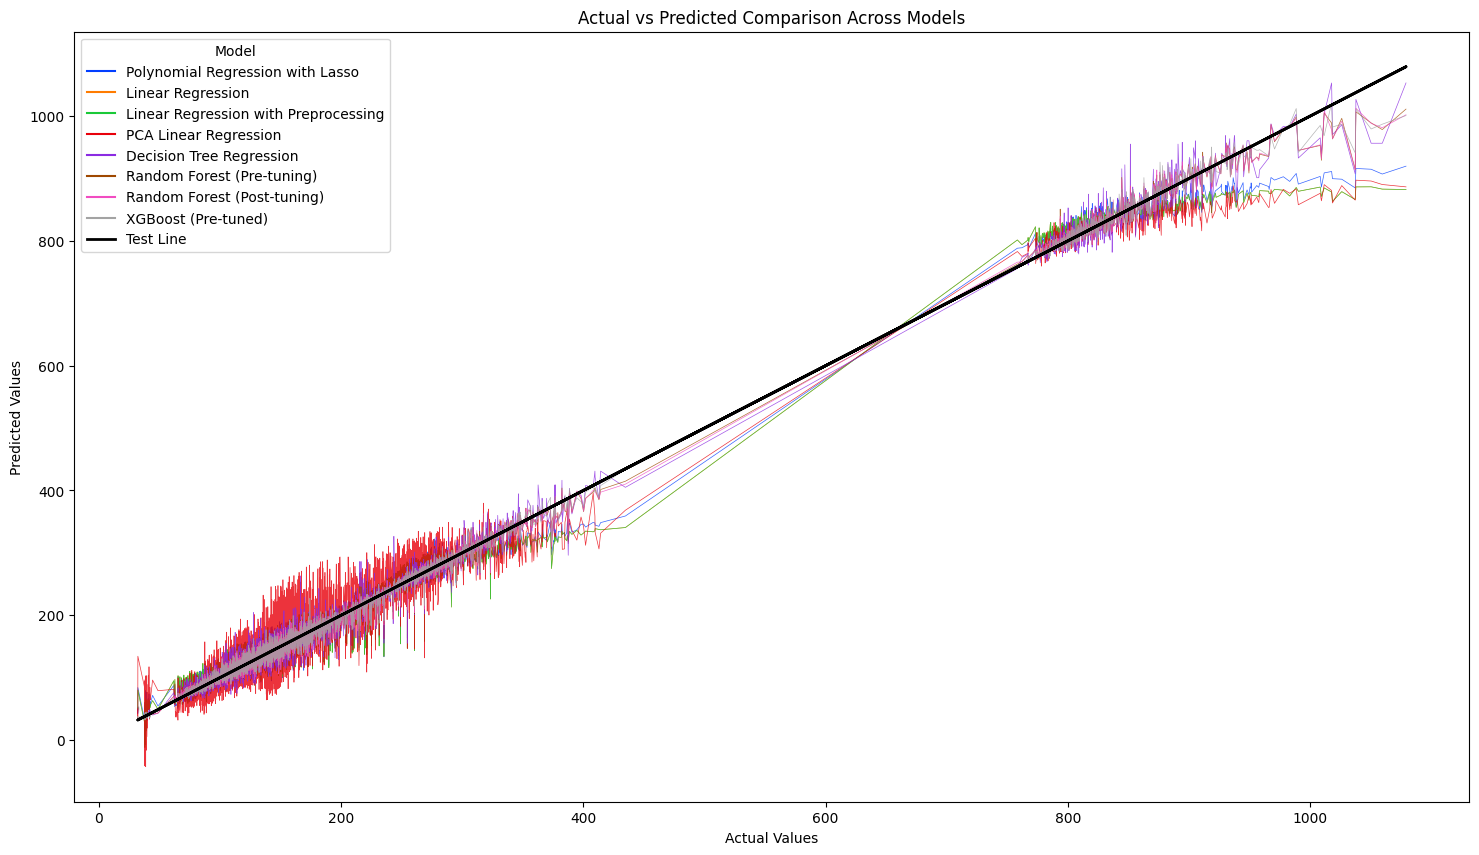

In [115]:
plt.figure(figsize=(18, 10))
sns.lineplot(x='Actual', y='Predicted', hue='Model', data=comparison_melted, alpha=0.8, palette='bright', linewidth=0.5)
plt.plot(comparison_df['Actual'], comparison_df['Actual'], label='Test Line', color='black', lw=2, alpha=1)
plt.title('Actual vs Predicted Comparison Across Models')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(title='Model')
plt.show()

<hr>
<h2>Extreme Gradient Boosting ++ (Hyperparameter tuning + Feature Selection)</h2>
<hr>

In [116]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(
    estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions = param_dist,
    n_iter = 10,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    random_state = 42,
    n_jobs = -1
)

random_search.fit(X_train, y_train)

best_parameters = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print("Best Parameters:", best_parameters)
print("Best RMSE:", best_rmse)

Best Parameters: {'colsample_bytree': 0.8925879806965068, 'learning_rate': 0.04993475643167195, 'max_depth': 9, 'n_estimators': 343, 'subsample': 0.7962072844310213}
Best RMSE: 7.670419097924025


In [117]:
best_mse = -random_search.best_score_
best_mse, best_rmse

(58.835329137797615, 7.670419097924025)

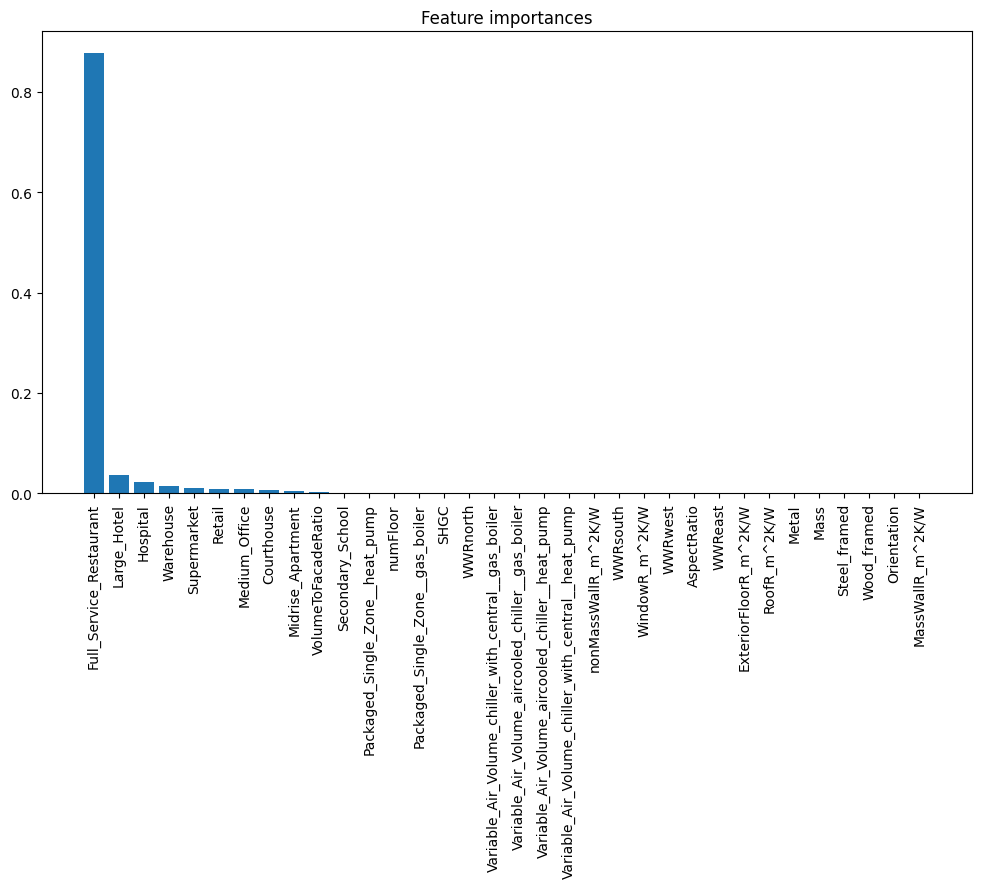

In [118]:
best_model = random_search.best_estimator_

importances = best_model.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

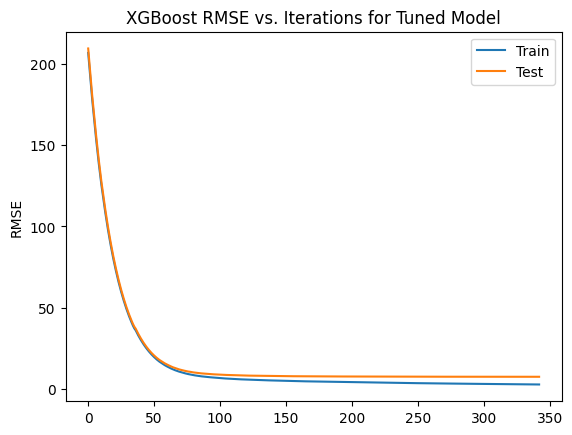

In [119]:
tuned_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=best_parameters['colsample_bytree'],
    learning_rate=best_parameters['learning_rate'],
    max_depth=best_parameters['max_depth'],
    n_estimators=best_parameters['n_estimators'],
    subsample=best_parameters['subsample'],
    random_state=42
)

eval_set = [(X_train, y_train), (X_test, y_test)]
tuned_model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

results = tuned_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE vs. Iterations for Tuned Model')
plt.show()

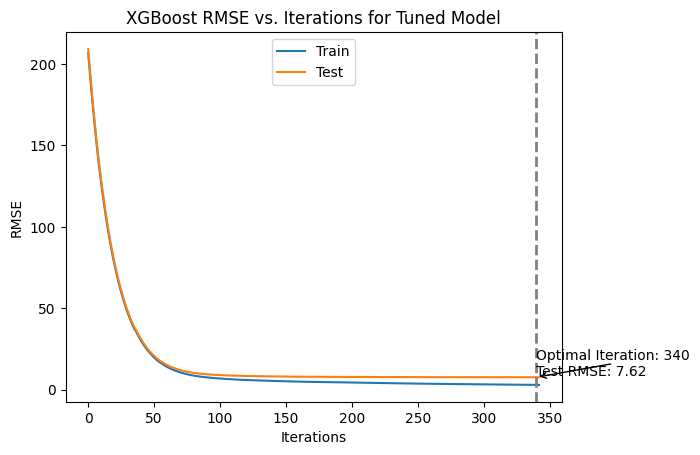

In [120]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

optimal_iterations = np.argmin(results['validation_1']['rmse'])
optimal_rmse = np.min(results['validation_1']['rmse'])

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

ax.axvline(x=optimal_iterations, color='gray', lw=2, linestyle='--')
ax.annotate(f'Optimal Iteration: {optimal_iterations}\nTest RMSE: {optimal_rmse:.2f}',
             xy=(optimal_iterations, optimal_rmse), xycoords='data',
             xytext=(optimal_iterations, optimal_rmse + 1), textcoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
             )

ax.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('XGBoost RMSE vs. Iterations for Tuned Model')
plt.show()

In [121]:
y_pred_xgb_tuned = tuned_model.predict(X_test)
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)
mse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned)
rmse_xgb_tuned = np.sqrt(mse_xgb_tuned)

In [122]:
model_comparison = add_model_results(
    model_comparison,
    'XGBoost (Post-tuning)',
    mse_xgb_tuned,
    rmse_xgb_tuned,
    r2_xgb_tuned
)

In [123]:
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138
2,Linear Regression with Preprocessing,380.883383,19.516234,0.992138
3,PCA Linear Regression,1009.804470,31.777421,0.979157
4,Decision Tree Regression,164.727118,12.834606,0.996600
5,Random Forest (Pre-tuning),80.288517,8.960386,0.998343
6,Random Forest (Post-tuning),80.574747,8.976344,0.998337
7,XGBoost (Pre-tuned),63.260267,7.953632,0.998694
8,XGBoost (Post-tuning),58.036042,7.618139,0.998802


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='MSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MSE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

In [124]:
comparison_df['XGBoost (Post-tuning)'] = y_pred_xgb_tuned
comparison_melted = comparison_df.melt('Actual', var_name='Model', value_name='Predicted')

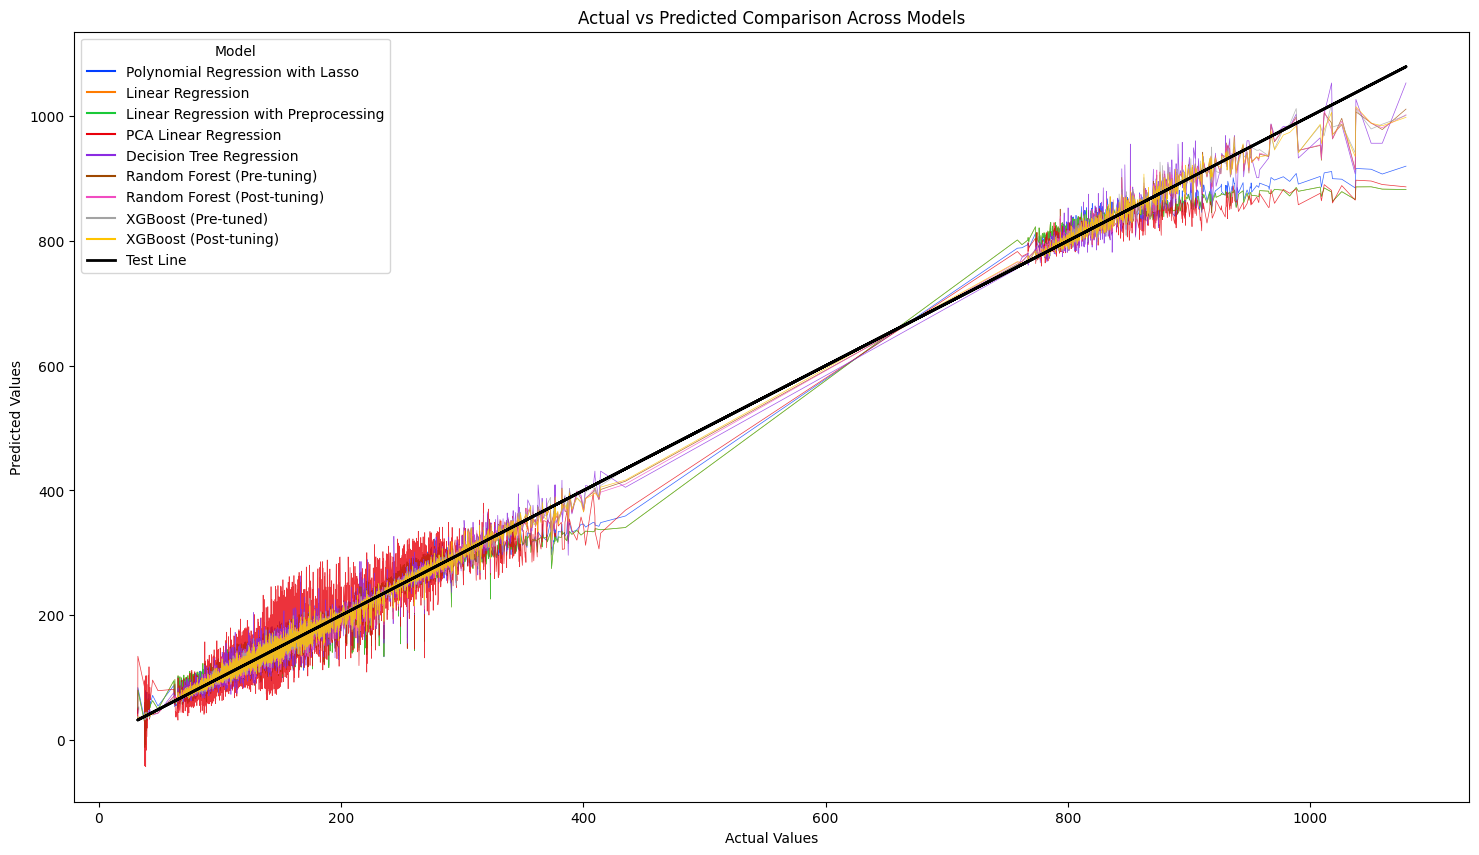

In [125]:
plt.figure(figsize=(18, 10))
sns.lineplot(x='Actual', y='Predicted', hue='Model', data=comparison_melted, alpha=0.8, palette='bright', linewidth=0.5)
plt.plot(comparison_df['Actual'], comparison_df['Actual'], label='Test Line', color='black', lw=2, alpha=1)
plt.title('Actual vs Predicted Comparison Across Models')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(title='Model')
plt.show()

Please refer to the plot prior to hyperparameter tuning.
After tuning, the RMSE starts much higher, but decreases more smoothly and continues improving across more iterations, marking the optimal iteration at 340 and test RMSE of 7.62. Further from this, the model does not improve, and may overfit if continued.

Summary Interpretations:

The hyperparameter tuning has improved the model's performance as indicated by a lower RMSE.
The training RMSE during the learning curve phase is significantly better than the initial model, showing that the model is capable of learning effectively.
The testing RMSE has not improved as much from the initial model to the learning curve testing phase, which could imply that the model might still be overfitting or that it has reached a performance plateau.
What is best?

The "Post-tuned Convergence" model has the lowest RMSE at 7.67, making it the best-performing model in terms of error minimization. This model is the most refined version you have and should be the preferred choice for making predictions.

In [126]:
model_comparison

,Model,MSE,RMSE,R2
0,Polynomial Regression with Lasso,302.581275,17.394863,0.993755
1,Linear Regression,380.887786,19.516347,0.992138
2,Linear Regression with Preprocessing,380.883383,19.516234,0.992138
3,PCA Linear Regression,1009.804470,31.777421,0.979157
4,Decision Tree Regression,164.727118,12.834606,0.996600
5,Random Forest (Pre-tuning),80.288517,8.960386,0.998343
6,Random Forest (Post-tuning),80.574747,8.976344,0.998337
7,XGBoost (Pre-tuned),63.260267,7.953632,0.998694
8,XGBoost (Post-tuning),58.036042,7.618139,0.998802
